In [1]:
from time import sleep
from gpiozero import DigitalOutputDevice
from datetime import datetime
from dataclasses import dataclass, asdict
import multiprocessing
from queue import Empty

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
try:
    from max31855 import MAX31855
except ImportError:
    print("Stubbing MAX31855 & Power")
    class MAX31855:
        stubbed = True
        temp = 0
        def getTemperature(self):
            self.temp += 1
            return self.temp

    class DigitalOutputDevice:
        stubbed = True
        def __init__(self, pin, initial_value):
            self.value = initial_value
        def on(self):
            self.value = True
        def off(self):
            self.value = False

In [3]:
class SimpleQueue:
    def __init__(self, depth):
        self.depth = depth
        self.queue = []

    def __getitem__(self, key):
        try:
            return self.queue[key]
        except:
            return None

    def __call__(self, value):
        self.queue.insert(0, value)
        while len(self.queue) > self.depth:
            self.queue.pop()

In [4]:
@dataclass
class KilnObservation:
    timestamp: str
    cycle: int
    temperature: float
    target: float
    power: float
    powerOn: bool
    setPower: float
    haltPowerChange: int
    powerStep: float
    slope: float
    accel: float
    cyclesUntilTarget: float
    error: float
    percentError: float
    realCycleTime: float
    lastTemperature: float

    def __repr__(self):
        reps = []
        for key, value in asdict(self).items():
            length = "10" if type(value) in [str, int, bool] else "10.8"
            reps.append("{key}: {value:<{length}}".format(key=key, value=value, length=length))
        return "Kiln=" + " | ".join(reps)

In [5]:
class KilnController:
    def __init__(self, targetQueue=None, stateQueue=None):
        self.maxPower = 70

        self.slopeBoost = 0.01
        self.accelBoost = 0.03
        
        self.cycleCount = 0
        self.cycleTime = 0.1
        self.realCycleTime = 1

        self.targetQueue = targetQueue
        try:
            self.targetTemp = self.targetQueue.get(block=False)
        except Empty:
            self.targetTemp = 0

        self.tempProbe = MAX31855()
    
        self.tempMemoryDepth = 60000
        self.tempMemory = SimpleQueue(self.tempMemoryDepth)
        self.tempMemory(self.temperature)
        
        self.setPower = 0
        self.setPowerMemory = SimpleQueue(60000)
        self.currentPower = 0
        self.powerWindow = 0.5

        self.power = DigitalOutputDevice(pin="GPIO17", initial_value=False)
        self.powerMemoryDepth = 60000
        self.powerOnMemory = SimpleQueue(self.powerMemoryDepth)
        self.powerMemory = SimpleQueue(self.powerMemoryDepth)
        
        self.restrictPowerChangeUntil = 0
        
        self.extendObservations(120)
        
        self.targetQueue = targetQueue
        self.stateQueue = stateQueue
    
    @property
    def filteredTemp(self):
        window = 10
        fT = []
        for i in range(0, window ** 2, window):
            selected = sorted(self.tempMemory.queue[i:i + window])[int(window / 2)]
            fT.extend([selected for i in range(window)])
        return fT[:self.tempMemoryDepth]
    
    @property
    def temperature(self):
        return self.tempProbe.getTemperature()
    
    def getCurrentPower(self):
        return (sum(self.powerOnMemory.queue) / len(self.powerOnMemory.queue)) * 100

    def observe(self):
        self.setPowerMemory(self.setPower)
        self.powerMemory(self.getCurrentPower())
        self.powerOnMemory(self.power.value)
        self.tempMemory(self.temperature)
    
    def extendObservations(self, n):
        self.setPowerMemory.queue = [self.setPower for i in range(n)] + self.setPowerMemory.queue
        self.powerOnMemory.queue = [self.power.value for i in range(n)] + self.powerOnMemory.queue
        
        pMValue = self.getCurrentPower()
        self.powerMemory.queue = [pMValue for i in range(n)] + self.powerMemory.queue
        
        currentTemp = self.temperature
        self.tempMemory.queue = [currentTemp for i in range(n)] + self.tempMemory.queue

    def processPower(self):
        try:
            local = self.powerOnMemory[:10]
            tooMuchEnergy = (sum(local) / 10) * 100 > self.maxPower
            wantPower = self.getCurrentPower() < min(self.setPower, self.maxPower)
            
            if tooMuchEnergy:
                print("Too Much Energy")
                self.power.off()
            elif wantPower:
                print("Energizing")
                self.power.on()
            else:
                print("Depowering")
                self.power.off()
        except:
            print("ERROR!")
            self.power.off()
            raise
    
    def setTargetTemperature(self, targetTemperature):
        print(f"Setting target temperature to: {targetTemperature}")
        self.targetTemp = min(int(targetTemperature), 2300)
        self.restrictPowerChangeUntil = 0
        
    def characterizeKiln(self):
        start = 0
        stop = 120
        obs = self.filteredTemp[start:stop]
        
        currentWindow = obs[:int(stop / 2)]
        secondWindow = obs[int(stop / 3):]

        temperature = currentWindow[0]
        error = self.targetTemp - temperature
        percentError = (error / (self.targetTemp if self.targetTemp != 0 else 1/10000)) * 100
        slope = (currentWindow[0] - currentWindow[-1]) / (len(currentWindow) * self.realCycleTime)
        secondWindowSlope = (secondWindow[0] - secondWindow[-1]) / (len(secondWindow) * self.realCycleTime)
        accel = (slope - secondWindowSlope) / 2
        if slope == 0 or (error * slope) < 0:
            cyclesUntilTarget = 99999
        else:
            cyclesUntilTarget = min(int(abs(error) / slope + 0.5), 99999)

            
        powerStep = min(max(25 * (error / 1500), 0.1), 5)

        state = KilnObservation(**{
            "timestamp": str(datetime.utcnow()),
            "cycle": self.cycleCount,
            "temperature": obs[0],
            "target": self.targetTemp,
            "power": self.getCurrentPower(),
            "powerOn": self.power.value,
            "setPower": self.setPower,
            "haltPowerChange": self.restrictPowerChangeUntil,
            "powerStep": powerStep,
            "slope": slope,
            "accel": accel,
            "cyclesUntilTarget": cyclesUntilTarget,
            "error": error,
            "percentError": percentError,
            "realCycleTime": self.realCycleTime,
            "lastTemperature": currentWindow[-1]
        })
        return state

    def tune(self):
        if self.targetTemp < 80:
            print("Kiln Disabled")
            self.setPower = 0
            return

        kilnChar = self.characterizeKiln()
        print(f"Tuning: {kilnChar}")
        
        newPower = self.setPower
        if kilnChar.percentError < 0.01:
            print("Hard Power Cutoff")
            newPower = 0
        elif (kilnChar.error > 0 and kilnChar.cyclesUntilTarget < 15):
            print("Preemptively Cutting Power")
            newPower = 0
        elif (
            self.cycleCount > self.restrictPowerChangeUntil and 
            (kilnChar.slope <= self.slopeBoost or kilnChar.accel <= self.accelBoost)
        ):
            print("Adding Energy")
            newPower = max(kilnChar.power + kilnChar.powerStep, self.setPower + kilnChar.powerStep)
            self.restrictPowerChangeUntil = self.cycleCount + 15

        if self.setPower != newPower:
            self.setPower = max(min(newPower, self.maxPower), 0)
            print(f"Tuned power to {self.setPower}")
        else:
            print("Holding power constant")
    
    def reportState(self, state=None):
        if self.stateQueue is None:
            return
        if state is None:
            state = self.characterizeKiln()
        self.stateQueue.put(state)
    
    def __repr__(self):
        return f"Kiln={self.characterizeKiln()}"

    def cycle(self):
        start = datetime.utcnow()
        sleep(self.cycleTime)
        if self.targetQueue is not None:
            try:
                self.setTargetTemperature(self.targetQueue.get(block=False))
            except Empty:
                pass

        self.cycleCount += 1
        self.observe()
        self.processPower()
        if len(self.tempMemory.queue) > 120:
            state = self.tune()
            self.reportState(state)
            self.realCycleTime = (datetime.utcnow() - start).total_seconds()
    
    def run(self):
        while True:
            self.cycle()

In [6]:
class KilnObserver:
    def __init__(self, stateQueue):
        self.stateQueue = stateQueue
        self.states = SimpleQueue(60000)
        self.cyclesBetweenRenders = 150
        self.renderWindow = 50
    
    def monitor(self):
        while True:
            state = self.stateQueue.get()
            self.states(state)
            if state.cycle > self.renderWindow:
                self.renderWindow = state.cycle + self.cyclesBetweenRenders
                self.renderKilnDrone()
            elif state.cycle % 10 == 0:
                print(f"Observer will start rendering in {self.renderWindow - state.cycle} cycles")

    def renderKilnDrone(self, cyclesAgo=6000, renderPowerImpluse=True):
        print("Observer Rendering KilnDrone")
        temperature = [s.temperature for s in self.states[:cyclesAgo]]
        targetTemperature = [s.target for s in self.states[:cyclesAgo]]
        setPower = [s.setPower for s in self.states[:cyclesAgo]]
        power = [s.power for s in self.states[:cyclesAgo]]
        powerImpulse = [s.powerOn * s.setPower for s in self.states[:cyclesAgo]]

        fig, ax = plt.subplots()
        ax.set_xlabel("Cycles Ago")
        ax2 = ax.twinx()
        ax.set_ylabel("Temperature (*F)")

        ln1 = ax.plot(temperature, color="green", label="Temperature", zorder=8)
        ln2 = ax.plot(targetTemperature, color="blue", label="Target Temperature", zorder=7)

        if renderPowerImpluse:
            ln3 = ax2.plot(powerImpulse, color="red", label="Power Impulse", zorder=4)

        ln4 = ax2.plot(setPower, color="darkred", label="Set Power", zorder=5)
        ln5 = ax2.plot(power, color="turquoise", label="Power", zorder=6)

        ax2.set_ylabel("Power Duty Cycle")
        lines = ln1 + ln2 + ln4 + ln5
        if renderPowerImpluse:
            lines = lines + ln3
        labels = [l.get_label() for l in lines]
        ax.legend(lines, labels, loc="upper right").set_zorder(100)
        plt.title("Temperature and Power over Time")
        ax.set_zorder(ax2.get_zorder() + 1)
        ax.patch.set_visible(False)
        display(plt.show())


In [7]:
class KilnDrone:
    def __init__(self):
        self.targetQueue = multiprocessing.Queue()
        self.stateQueue = multiprocessing.Queue()
        self.controller = KilnController(targetQueue=self.targetQueue, stateQueue=self.stateQueue)
        self.observer = KilnObserver(stateQueue=self.stateQueue)
    
    def run(self, target=None):
        if target is not None:
            self.targetQueue.put(target)
        
        controllerProc = multiprocessing.Process(target=self.controller.run)
        monitorProc = multiprocessing.Process(target=self.observer.monitor)
        
        try:
            print("Starting kiln processes")
            controllerProc.start()
            monitorProc.start()
            controllerProc.join()
        except:
            print("Killing processes")
            controllerProc.terminate()
            monitorProc.terminate()
        finally:
            print("Setting heater power to off")
            self.controller.power.off()

In [8]:
k = KilnDrone()

Starting kiln processes
Setting target temperature to: 1700
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:37:41.255226 | cycle: 1          | temperature: 1396.4     | target: 1700       | power: 0.0        | powerOn: 0          | setPower: 0          | haltPowerChange: 0          | powerStep: 5          | slope: 0.0        | accel: 0.0        | cyclesUntilTarget: 99999      | error: 303.6      | percentError: 17.858824  | realCycleTime: 1          | lastTemperature: 1396.4    
Adding Energy
Tuned power to 5.0
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:37:42.014952 | cycle: 2          | temperature: 1396.4     | target: 1700       | power: 0.0        | powerOn: 1          | setPower: 5.0        | haltPowerChange: 16         | powerStep: 5          | slope: 0.0        | accel: 0.0        | cyclesUntilTarget: 99999      | error: 303.6      | percentError: 17.858824  | realCycleTime: 0.863969   | lastTemperature: 1396.4    
Holding power constant
Energizing
Tuning: Kiln=timestamp:

Tuning: Kiln=timestamp: 2021-10-05 15:37:52.908467 | cycle: 19         | temperature: 1434.65    | target: 1700       | power: 5.0359712  | powerOn: 0          | setPower: 5.0        | haltPowerChange: 16         | powerStep: 4.4225     | slope: 1.0004708  | accel: 0.5002354  | cyclesUntilTarget: 265        | error: 265.35     | percentError: 15.608824  | realCycleTime: 0.6372     | lastTemperature: 1396.4    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:37:53.545626 | cycle: 20         | temperature: 1434.65    | target: 1700       | power: 5.0        | powerOn: 0          | setPower: 5.0        | haltPowerChange: 16         | powerStep: 4.4225     | slope: 0.98299079 | accel: 0.49149539 | cyclesUntilTarget: 270        | error: 265.35     | percentError: 15.608824  | realCycleTime: 0.648531   | lastTemperature: 1396.4    
Holding power constant
Observer will start rendering in 30 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:37:54.201560 | cycle: 2

Tuning: Kiln=timestamp: 2021-10-05 15:38:04.445414 | cycle: 37         | temperature: 1436.45    | target: 1700       | power: 5.0955414  | powerOn: 0          | setPower: 5.0        | haltPowerChange: 16         | powerStep: 4.3925     | slope: 1.0514626  | accel: 0.5257313  | cyclesUntilTarget: 251        | error: 263.55     | percentError: 15.502941  | realCycleTime: 0.63483    | lastTemperature: 1396.4    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:38:05.084020 | cycle: 38         | temperature: 1436.0     | target: 1700       | power: 5.0632911  | powerOn: 0          | setPower: 5.0        | haltPowerChange: 16         | powerStep: 4.4        | slope: 1.0303758  | accel: 0.5151879  | cyclesUntilTarget: 256        | error: 264.0      | percentError: 15.529412  | realCycleTime: 0.640543   | lastTemperature: 1396.4    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:38:05.719998 | cycle: 39         | temperature: 1436.0     | targe

Tuning: Kiln=timestamp: 2021-10-05 15:38:16.336830 | cycle: 55         | temperature: 1436.9     | target: 1700       | power: 5.1428571  | powerOn: 0          | setPower: 5.0        | haltPowerChange: 16         | powerStep: 4.385      | slope: 0.50885337 | accel: -0.13739041 | cyclesUntilTarget: 517        | error: 263.1      | percentError: 15.476471  | realCycleTime: 0.736951   | lastTemperature: 1414.4    
Adding Energy
Tuned power to 9.52785714285714
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:38:17.197148 | cycle: 56         | temperature: 1436.9     | target: 1700       | power: 5.1136364  | powerOn: 1          | setPower: 9.5278571  | haltPowerChange: 70         | powerStep: 4.385      | slope: 0.43883978 | accel: -0.13165193 | cyclesUntilTarget: 600        | error: 263.1      | percentError: 15.476471  | realCycleTime: 0.854526   | lastTemperature: 1414.4    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:38:17.934984 | cycle: 57         | temper

Tuning: Kiln=timestamp: 2021-10-05 15:38:29.757148 | cycle: 73         | temperature: 1461.65    | target: 1700       | power: 10.362694  | powerOn: 1          | setPower: 13.957644  | haltPowerChange: 86         | powerStep: 3.9725     | slope: 0.60441902 | accel: -0.15878805 | cyclesUntilTarget: 394        | error: 238.35     | percentError: 14.020588  | realCycleTime: 0.732108   | lastTemperature: 1435.1    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:38:30.506761 | cycle: 74         | temperature: 1461.65    | target: 1700       | power: 10.824742  | powerOn: 1          | setPower: 13.957644  | haltPowerChange: 86         | powerStep: 3.9725     | slope: 0.59796812 | accel: -0.15709332 | cyclesUntilTarget: 399        | error: 238.35     | percentError: 14.020588  | realCycleTime: 0.740006   | lastTemperature: 1435.1    
Holding power constant


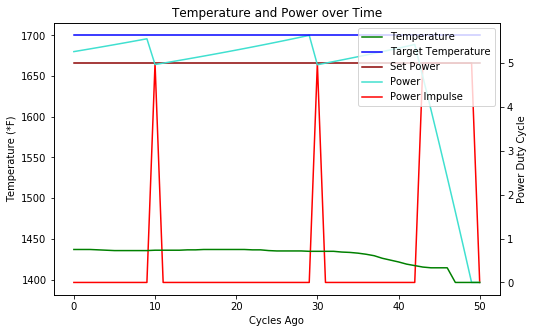

None

Energizing
Observer will start rendering in 141 cyclesTuning: Kiln=timestamp: 2021-10-05 15:38:31.334553 | cycle: 75         | temperature: 1463.0     | target: 1700       | power: 11.282051  | powerOn: 1          | setPower: 13.957644  | haltPowerChange: 86         | powerStep: 3.95       | slope: 0.6073866  | accel: -0.13715181 | cyclesUntilTarget: 390        | error: 237.0      | percentError: 13.941176  | realCycleTime: 0.765575   | lastTemperature: 1435.1    

Observer will start rendering in 131 cyclesHolding power constant

Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:38:32.123996 | cycle: 76         | temperature: 1464.8     | target: 1700       | power: 11.734694  | powerOn: 1          | setPower: 13.957644  | haltPowerChange: 86         | powerStep: 3.92       | slope: 0.54717838 | accel: -0.095341688 | cyclesUntilTarget: 430        | error: 235.2      | percentError: 13.835294  | realCycleTime: 0.904641   | lastTemperature: 1435.1    
Holding power constant
Energizing
Tu

Tuning: Kiln=timestamp: 2021-10-05 15:38:42.355074 | cycle: 92         | temperature: 1493.6     | target: 1700       | power: 14.150943  | powerOn: 0          | setPower: 13.957644  | haltPowerChange: 86         | powerStep: 3.44       | slope: 1.4796338  | accel: 0.22366558 | cyclesUntilTarget: 139        | error: 206.4      | percentError: 12.141176  | realCycleTime: 0.653878   | lastTemperature: 1435.55   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:38:42.986740 | cycle: 93         | temperature: 1494.5     | target: 1700       | power: 14.084507  | powerOn: 0          | setPower: 13.957644  | haltPowerChange: 86         | powerStep: 3.425      | slope: 1.5448769  | accel: 0.24175555 | cyclesUntilTarget: 133        | error: 205.5      | percentError: 12.088235  | realCycleTime: 0.635973   | lastTemperature: 1435.55   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:38:43.627513 | cycle: 94         | temperature: 1494.95    | targe

Tuning: Kiln=timestamp: 2021-10-05 15:38:53.843825 | cycle: 110        | temperature: 1491.8     | target: 1700       | power: 13.913043  | powerOn: 1          | setPower: 13.957644  | haltPowerChange: 86         | powerStep: 3.47       | slope: 1.4387471  | accel: 0.41275532 | cyclesUntilTarget: 145        | error: 208.2      | percentError: 12.247059  | realCycleTime: 0.63597    | lastTemperature: 1436.9    
Holding power constant
Observer will start rendering in 91 cycles
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:38:54.500108 | cycle: 111        | temperature: 1491.8     | target: 1700       | power: 14.285714  | powerOn: 0          | setPower: 13.957644  | haltPowerChange: 86         | powerStep: 3.47       | slope: 1.4439966  | accel: 0.39650726 | cyclesUntilTarget: 144        | error: 208.2      | percentError: 12.247059  | realCycleTime: 0.633658   | lastTemperature: 1436.9    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:38:55.139069 | cycle: 1

Tuning: Kiln=timestamp: 2021-10-05 15:39:05.477850 | cycle: 128        | temperature: 1493.6     | target: 1700       | power: 16.532258  | powerOn: 1          | setPower: 17.718441  | haltPowerChange: 134        | powerStep: 3.44       | slope: 0.70914051 | accel: -0.34866075 | cyclesUntilTarget: 291        | error: 206.4      | percentError: 12.141176  | realCycleTime: 0.634571   | lastTemperature: 1466.6    
Holding power constant
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:39:06.117865 | cycle: 129        | temperature: 1495.4     | target: 1700       | power: 16.86747   | powerOn: 0          | setPower: 17.718441  | haltPowerChange: 134        | powerStep: 3.41       | slope: 0.65713199 | accel: -0.39310575 | cyclesUntilTarget: 311        | error: 204.6      | percentError: 12.035294  | realCycleTime: 0.639141   | lastTemperature: 1470.2    
Holding power constant
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:39:06.761225 | cycle: 130        | temperature: 1498.1

Holding power constant
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:39:17.116141 | cycle: 146        | temperature: 1525.1     | target: 1700       | power: 20.300752  | powerOn: 0          | setPower: 21.254216  | haltPowerChange: 150        | powerStep: 2.915      | slope: 0.79114173 | accel: -0.34243448 | cyclesUntilTarget: 221        | error: 174.9      | percentError: 10.288235  | realCycleTime: 0.635158   | lastTemperature: 1494.95   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:39:17.754727 | cycle: 147        | temperature: 1526.0     | target: 1700       | power: 20.224719  | powerOn: 1          | setPower: 21.254216  | haltPowerChange: 150        | powerStep: 2.9        | slope: 0.81036896 | accel: -0.32297314 | cyclesUntilTarget: 215        | error: 174.0      | percentError: 10.235294  | realCycleTime: 0.638598   | lastTemperature: 1494.95   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:39:18.384508 | cycle: 148

Tuning: Kiln=timestamp: 2021-10-05 15:39:28.049434 | cycle: 163        | temperature: 1548.5     | target: 1700       | power: 23.321555  | powerOn: 0          | setPower: 24.204714  | haltPowerChange: 166        | powerStep: 2.525      | slope: 1.4883022  | accel: 0.37500527 | cyclesUntilTarget: 102        | error: 151.5      | percentError: 8.9117647  | realCycleTime: 0.639991   | lastTemperature: 1491.35   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:39:28.694458 | cycle: 164        | temperature: 1550.3     | target: 1700       | power: 23.239437  | powerOn: 1          | setPower: 24.204714  | haltPowerChange: 166        | powerStep: 2.495      | slope: 1.5478291  | accel: 0.40172664 | cyclesUntilTarget: 97         | error: 149.7      | percentError: 8.8058824  | realCycleTime: 0.63476    | lastTemperature: 1491.35   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:39:29.320693 | cycle: 165        | temperature: 1551.65    | targe

Tuning: Kiln=timestamp: 2021-10-05 15:39:39.845085 | cycle: 181        | temperature: 1562.45    | target: 1700       | power: 24.252492  | powerOn: 0          | setPower: 24.204714  | haltPowerChange: 166        | powerStep: 2.2925     | slope: 1.625212   | accel: 0.51818353 | cyclesUntilTarget: 85         | error: 137.55     | percentError: 8.0911765  | realCycleTime: 0.63684    | lastTemperature: 1500.35   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:39:40.469744 | cycle: 182        | temperature: 1562.45    | target: 1700       | power: 24.172185  | powerOn: 1          | setPower: 24.204714  | haltPowerChange: 166        | powerStep: 2.2925     | slope: 1.5227659  | accel: 0.45225003 | cyclesUntilTarget: 90         | error: 137.55     | percentError: 8.0911765  | realCycleTime: 0.655058   | lastTemperature: 1502.6    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:39:41.114593 | cycle: 183        | temperature: 1562.0     | targe

Tuning: Kiln=timestamp: 2021-10-05 15:39:51.419644 | cycle: 199        | temperature: 1556.6     | target: 1700       | power: 25.705329  | powerOn: 1          | setPower: 26.733974  | haltPowerChange: 207        | powerStep: 2.39       | slope: 0.72735691 | accel: -0.30502064 | cyclesUntilTarget: 197        | error: 143.4      | percentError: 8.4352941  | realCycleTime: 0.639301   | lastTemperature: 1528.7    
Holding power constant
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:39:52.055903 | cycle: 200        | temperature: 1557.5     | target: 1700       | power: 25.9375    | powerOn: 0          | setPower: 26.733974  | haltPowerChange: 207        | powerStep: 2.375      | slope: 0.70796683 | accel: -0.33628424 | cyclesUntilTarget: 201        | error: 142.5      | percentError: 8.3823529  | realCycleTime: 0.635623   | lastTemperature: 1530.5    
Holding power constant
Observer will start rendering in 1 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:39:52.711524 | cy

Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:40:04.567086 | cycle: 217        | temperature: 1583.15    | target: 1700       | power: 27.893175  | powerOn: 1          | setPower: 29.001768  | haltPowerChange: 223        | powerStep: 1.9475     | slope: 0.66333751 | accel: -0.46943885 | cyclesUntilTarget: 176        | error: 116.85     | percentError: 6.8735294  | realCycleTime: 0.73492    | lastTemperature: 1553.9    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:40:05.295942 | cycle: 218        | temperature: 1584.95    | target: 1700       | power: 28.106509  | powerOn: 1          | setPower: 29.001768  | haltPowerChange: 223        | powerStep: 1.9175     | slope: 0.68602219 | accel: -0.45734813 | cyclesUntilTarget: 168        | error: 115.05     | percentError: 6.7676471  | realCycleTime: 0.721551   | lastTemperature: 1555.25   
Holding power constant
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:40:06.047090 | cycle: 219        | temperature: 

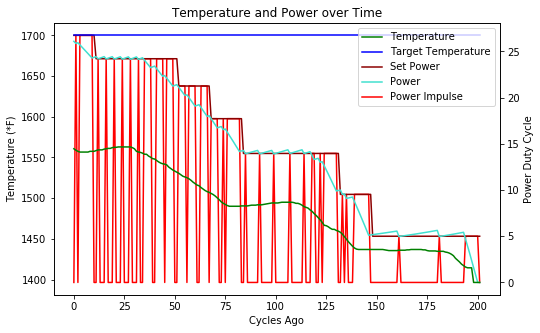


Holding power constant


None

Observer will start rendering in 142 cycles
Observer will start rendering in 132 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:40:12.224749 | cycle: 227        | temperature: 1594.85    | target: 1700       | power: 29.106628  | powerOn: 1          | setPower: 30.882267  | haltPowerChange: 239        | powerStep: 1.7525     | slope: 0.68460745 | accel: -0.20248953 | cyclesUntilTarget: 154        | error: 105.15     | percentError: 6.1852941  | realCycleTime: 0.777818   | lastTemperature: 1562.9    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:40:12.856108 | cycle: 228        | temperature: 1597.1     | target: 1700       | power: 29.310345  | powerOn: 1          | setPower: 30.882267  | haltPowerChange: 239        | powerStep: 1.715      | slope: 0.6881332  | accel: -0.14034296 | cyclesUntilTarget: 150        | error: 102.9      | percentError: 6.0529412  | realCycleTime: 0.828328   | lastTemperature: 1562.9    
Holding power constant
Energizing
Tun

Tuning: Kiln=timestamp: 2021-10-05 15:40:23.054942 | cycle: 244        | temperature: 1613.3     | target: 1700       | power: 31.043956  | powerOn: 0          | setPower: 30.882267  | haltPowerChange: 239        | powerStep: 1.445      | slope: 1.4763873  | accel: 0.36314366 | cyclesUntilTarget: 59         | error: 86.7       | percentError: 5.1        | realCycleTime: 0.629916   | lastTemperature: 1557.5    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:40:23.693929 | cycle: 245        | temperature: 1614.65    | target: 1700       | power: 30.958904  | powerOn: 0          | setPower: 30.882267  | haltPowerChange: 239        | powerStep: 1.4225     | slope: 1.4925189  | accel: 0.38180716 | cyclesUntilTarget: 57         | error: 85.35      | percentError: 5.0205882  | realCycleTime: 0.648233   | lastTemperature: 1556.6    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:40:24.331142 | cycle: 246        | temperature: 1616.0     | targe

Tuning: Kiln=timestamp: 2021-10-05 15:40:34.576318 | cycle: 262        | temperature: 1611.05    | target: 1700       | power: 30.890052  | powerOn: 0          | setPower: 30.882267  | haltPowerChange: 239        | powerStep: 1.4825     | slope: 0.92060659 | accel: 0.11933789 | cyclesUntilTarget: 97         | error: 88.95      | percentError: 5.2323529  | realCycleTime: 0.659891   | lastTemperature: 1574.6    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:40:35.212227 | cycle: 263        | temperature: 1610.6     | target: 1700       | power: 30.809399  | powerOn: 1          | setPower: 30.882267  | haltPowerChange: 239        | powerStep: 1.49       | slope: 0.88615332 | accel: 0.082707643 | cyclesUntilTarget: 101        | error: 89.4       | percentError: 5.2588235  | realCycleTime: 0.634766   | lastTemperature: 1576.85   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:40:35.845084 | cycle: 264        | temperature: 1610.15    | targ

Tuning: Kiln=timestamp: 2021-10-05 15:40:46.165642 | cycle: 280        | temperature: 1618.25    | target: 1700       | power: 32.5       | powerOn: 0          | setPower: 32.406591  | haltPowerChange: 280        | powerStep: 1.3625     | slope: 0.49314374 | accel: -0.42856539 | cyclesUntilTarget: 166        | error: 81.75      | percentError: 4.8088235  | realCycleTime: 0.638759   | lastTemperature: 1599.35   
Holding power constant
Observer will start rendering in 72 cycles
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:40:46.815917 | cycle: 281        | temperature: 1618.7     | target: 1700       | power: 32.418953  | powerOn: 0          | setPower: 32.406591  | haltPowerChange: 280        | powerStep: 1.355      | slope: 0.49748415 | accel: -0.45010471 | cyclesUntilTarget: 163        | error: 81.3       | percentError: 4.7823529  | realCycleTime: 0.633186   | lastTemperature: 1599.8    
Adding Energy
Tuned power to 33.77395261845386
Energizing
Tuning: Kiln=timestamp: 2021-10-05 

Tuned power to 34.927949640287764
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:40:57.836762 | cycle: 298        | temperature: 1633.1     | target: 1700       | power: 33.732057  | powerOn: 1          | setPower: 34.92795   | haltPowerChange: 312        | powerStep: 1.115      | slope: 0.37988097 | accel: -0.2949076 | cyclesUntilTarget: 176        | error: 66.9       | percentError: 3.9352941  | realCycleTime: 0.750235   | lastTemperature: 1616.0    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:40:58.471507 | cycle: 299        | temperature: 1634.0     | target: 1700       | power: 33.890215  | powerOn: 1          | setPower: 34.92795   | haltPowerChange: 312        | powerStep: 1.1        | slope: 0.47258979 | accel: -0.31899811 | cyclesUntilTarget: 140        | error: 66.0       | percentError: 3.8823529  | realCycleTime: 0.6348     | lastTemperature: 1616.0    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:40:59.114847 | cycle

Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:41:09.367480 | cycle: 316        | temperature: 1646.6     | target: 1700       | power: 34.862385  | powerOn: 1          | setPower: 34.92795   | haltPowerChange: 312        | powerStep: 0.89       | slope: 0.95193921 | accel: 0.22917055 | cyclesUntilTarget: 56         | error: 53.4       | percentError: 3.1411765  | realCycleTime: 0.638171   | lastTemperature: 1610.15   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:41:10.005726 | cycle: 317        | temperature: 1646.6     | target: 1700       | power: 35.011442  | powerOn: 0          | setPower: 34.92795   | haltPowerChange: 312        | powerStep: 0.89       | slope: 0.96132503 | accel: 0.22860778 | cyclesUntilTarget: 56         | error: 53.4       | percentError: 3.1411765  | realCycleTime: 0.639742   | lastTemperature: 1609.7    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:41:10.644165 | cycle: 318       

Tuning: Kiln=timestamp: 2021-10-05 15:41:20.894840 | cycle: 334        | temperature: 1640.75    | target: 1700       | power: 35.022026  | powerOn: 0          | setPower: 34.92795   | haltPowerChange: 312        | powerStep: 0.9875     | slope: 0.52301338 | accel: 0.047546671 | cyclesUntilTarget: 113        | error: 59.25      | percentError: 3.4852941  | realCycleTime: 0.630959   | lastTemperature: 1620.95   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:41:21.532787 | cycle: 335        | temperature: 1640.3     | target: 1700       | power: 34.945055  | powerOn: 0          | setPower: 34.92795   | haltPowerChange: 312        | powerStep: 0.995      | slope: 0.48510453 | accel: 0.023663636 | cyclesUntilTarget: 123        | error: 59.7       | percentError: 3.5117647  | realCycleTime: 0.633884   | lastTemperature: 1621.85   
Adding Energy
Tuned power to 35.94005494505494
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:41:22.259617 | cycle: 336        | tempe

Tuned power to 36.78505494505494
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:41:32.793971 | cycle: 352        | temperature: 1649.3     | target: 1700       | power: 36.016949  | powerOn: 1          | setPower: 36.785055  | haltPowerChange: 366        | powerStep: 0.845      | slope: 0.26607287 | accel: -0.2128583 | cyclesUntilTarget: 191        | error: 50.7       | percentError: 2.9823529  | realCycleTime: 0.845633   | lastTemperature: 1635.8    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:41:33.462140 | cycle: 353        | temperature: 1649.75    | target: 1700       | power: 36.15222   | powerOn: 1          | setPower: 36.785055  | haltPowerChange: 366        | powerStep: 0.8375     | slope: 0.33307723 | accel: -0.27201307 | cyclesUntilTarget: 151        | error: 50.25      | percentError: 2.9558824  | realCycleTime: 0.675519   | lastTemperature: 1636.25   
Holding power constant
Observer Rendering KilnDrone
Energizing
Tuning: Kiln=timestamp: 2021-1

Tuning: Kiln=timestamp: 2021-10-05 15:41:46.716056 | cycle: 370        | temperature: 1663.25    | target: 1700       | power: 37.142857  | powerOn: 1          | setPower: 37.397555  | haltPowerChange: 382        | powerStep: 0.6125     | slope: 0.38080888 | accel: -0.082337055 | cyclesUntilTarget: 97         | error: 36.75      | percentError: 2.1617647  | realCycleTime: 0.728712   | lastTemperature: 1646.6    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:41:47.447026 | cycle: 371        | temperature: 1663.25    | target: 1700       | power: 37.270876  | powerOn: 1          | setPower: 37.397555  | haltPowerChange: 382        | powerStep: 0.6125     | slope: 0.38944109 | accel: -0.066614923 | cyclesUntilTarget: 94         | error: 36.75      | percentError: 2.1617647  | realCycleTime: 0.731818   | lastTemperature: 1646.15   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:41:48.182998 | cycle: 372        | temperature: 1663.25    | t

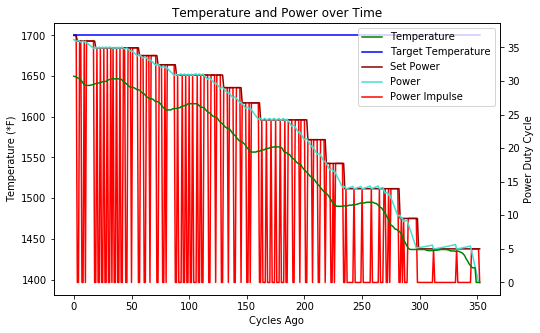

None

Observer will start rendering in 143 cycles
Depowering
Observer will start rendering in 133 cyclesTuning: Kiln=timestamp: 2021-10-05 15:41:54.286782 | cycle: 380        | temperature: 1668.2     | target: 1700       | power: 37.4       | powerOn: 0          | setPower: 37.397555  | haltPowerChange: 382        | powerStep: 0.53       | slope: 0.56110425 | accel: 0.13543896 | cyclesUntilTarget: 57         | error: 31.8       | percentError: 1.8705882  | realCycleTime: 0.775257   | lastTemperature: 1642.1    

Holding power constant
Observer will start rendering in 123 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:41:55.046311 | cycle: 381        | temperature: 1668.2     | target: 1700       | power: 37.325349  | powerOn: 1          | setPower: 37.397555  | haltPowerChange: 382        | powerStep: 0.53       | slope: 0.47119181 | accel: 0.12778083 | cyclesUntilTarget: 67         | error: 31.8       | percentError: 1.8705882  | realCycleTime: 0.939108   | lastTemperature: 1641.6

Tuning: Kiln=timestamp: 2021-10-05 15:42:05.292454 | cycle: 397        | temperature: 1661.9     | target: 1700       | power: 37.330754  | powerOn: 1          | setPower: 37.397555  | haltPowerChange: 382        | powerStep: 0.635      | slope: 0.4365143  | accel: 0.076684945 | cyclesUntilTarget: 87         | error: 38.1       | percentError: 2.2411765  | realCycleTime: 0.635718   | lastTemperature: 1645.25   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:42:05.926639 | cycle: 398        | temperature: 1661.9     | target: 1700       | power: 37.451737  | powerOn: 0          | setPower: 37.397555  | haltPowerChange: 382        | powerStep: 0.635      | slope: 0.39035761 | accel: 0.053230584 | cyclesUntilTarget: 98         | error: 38.1       | percentError: 2.2411765  | realCycleTime: 0.634034   | lastTemperature: 1647.05   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:42:06.578444 | cycle: 399        | temperature: 1661.45    | tar

Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:42:16.906063 | cycle: 415        | temperature: 1669.1     | target: 1700       | power: 38.130841  | powerOn: 0          | setPower: 38.040055  | haltPowerChange: 414        | powerStep: 0.515      | slope: 0.15338702 | accel: -0.20058303 | cyclesUntilTarget: 201        | error: 30.9       | percentError: 1.8176471  | realCycleTime: 0.635647   | lastTemperature: 1663.25   
Adding Energy
Tuned power to 38.64584112149533
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:42:17.642052 | cycle: 416        | temperature: 1669.1     | target: 1700       | power: 38.059701  | powerOn: 1          | setPower: 38.645841  | haltPowerChange: 430        | powerStep: 0.515      | slope: 0.1319288  | accel: -0.18774483 | cyclesUntilTarget: 234        | error: 30.9       | percentError: 1.8176471  | realCycleTime: 0.739035   | lastTemperature: 1663.25   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:42:18.

Tuning: Kiln=timestamp: 2021-10-05 15:42:27.974606 | cycle: 432        | temperature: 1677.65    | target: 1700       | power: 38.586957  | powerOn: 1          | setPower: 39.029487  | haltPowerChange: 446        | powerStep: 0.3725     | slope: 0.20329086 | accel: -0.17424931 | cyclesUntilTarget: 110        | error: 22.35      | percentError: 1.3147059  | realCycleTime: 0.774752   | lastTemperature: 1668.2    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:42:28.603777 | cycle: 433        | temperature: 1677.65    | target: 1700       | power: 38.698011  | powerOn: 1          | setPower: 39.029487  | haltPowerChange: 446        | powerStep: 0.3725     | slope: 0.24617914 | accel: -0.21101069 | cyclesUntilTarget: 91         | error: 22.35      | percentError: 1.3147059  | realCycleTime: 0.639778   | lastTemperature: 1668.2    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:42:29.239647 | cycle: 434        | temperature: 1677.65    | tar

Tuning: Kiln=timestamp: 2021-10-05 15:42:39.470079 | cycle: 450        | temperature: 1679.0     | target: 1700       | power: 39.122807  | powerOn: 0          | setPower: 39.029487  | haltPowerChange: 446        | powerStep: 0.35       | slope: 0.46867384 | accel: 0.093734768 | cyclesUntilTarget: 45         | error: 21.0       | percentError: 1.2352941  | realCycleTime: 0.640104   | lastTemperature: 1661.0    
Holding power constant
Observer will start rendering in 53 cycles
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:42:40.119416 | cycle: 451        | temperature: 1679.0     | target: 1700       | power: 39.054291  | powerOn: 0          | setPower: 39.029487  | haltPowerChange: 446        | powerStep: 0.35       | slope: 0.47593438 | accel: 0.11303441 | cyclesUntilTarget: 44         | error: 21.0       | percentError: 1.2352941  | realCycleTime: 0.630339   | lastTemperature: 1661.0    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:42:40.754785 | cycle: 

Tuning: Kiln=timestamp: 2021-10-05 15:42:51.045420 | cycle: 468        | temperature: 1674.95    | target: 1700       | power: 39.455782  | powerOn: 1          | setPower: 39.465568  | haltPowerChange: 476        | powerStep: 0.4175     | slope: 0.16653212 | accel: -0.04163303 | cyclesUntilTarget: 150        | error: 25.05      | percentError: 1.4735294  | realCycleTime: 0.630509   | lastTemperature: 1668.65   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:42:51.695944 | cycle: 469        | temperature: 1674.95    | target: 1700       | power: 39.558574  | powerOn: 0          | setPower: 39.465568  | haltPowerChange: 476        | powerStep: 0.4175     | slope: 0.1611611  | accel: -0.040290274 | cyclesUntilTarget: 155        | error: 25.05      | percentError: 1.4735294  | realCycleTime: 0.651522   | lastTemperature: 1668.65   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:42:52.326046 | cycle: 470        | temperature: 1676.3     | ta

Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:43:02.716599 | cycle: 486        | temperature: 1683.95    | target: 1700       | power: 39.933993  | powerOn: 0          | setPower: 39.835988  | haltPowerChange: 492        | powerStep: 0.2675     | slope: 0.17382141 | accel: -0.14485118 | cyclesUntilTarget: 92         | error: 16.05      | percentError: 0.94411765 | realCycleTime: 0.647216   | lastTemperature: 1677.2    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:43:03.347744 | cycle: 487        | temperature: 1685.75    | target: 1700       | power: 39.868204  | powerOn: 0          | setPower: 39.835988  | haltPowerChange: 492        | powerStep: 0.2375     | slope: 0.22201449 | accel: -0.1285347 | cyclesUntilTarget: 64         | error: 14.25      | percentError: 0.83823529 | realCycleTime: 0.64185    | lastTemperature: 1677.2    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:43:03.988313 | cycle: 488        | temperature: 1686.2

Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:43:14.386266 | cycle: 504        | temperature: 1688.45    | target: 1700       | power: 40.064103  | powerOn: 0          | setPower: 40.050988  | haltPowerChange: 508        | powerStep: 0.1925     | slope: 0.26956663 | accel: 0.052741297 | cyclesUntilTarget: 43         | error: 11.55      | percentError: 0.67941176 | realCycleTime: 0.639916   | lastTemperature: 1678.1    
Holding power constant
Observer Rendering KilnDrone
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:43:15.126806 | cycle: 505        | temperature: 1688.45    | target: 1700       | power: 40.0       | powerOn: 1          | setPower: 40.050988  | haltPowerChange: 508        | powerStep: 0.1925     | slope: 0.27627065 | accel: 0.063312025 | cyclesUntilTarget: 42         | error: 11.55      | percentError: 0.67941176 | realCycleTime: 0.651535   | lastTemperature: 1677.65   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:43:15.886752 | cycle: 50

Tuning: Kiln=timestamp: 2021-10-05 15:43:27.987081 | cycle: 522        | temperature: 1688.9     | target: 1700       | power: 40.342679  | powerOn: 0          | setPower: 40.310087  | haltPowerChange: 526        | powerStep: 0.185      | slope: 0.19774335 | accel: 0.054379422 | cyclesUntilTarget: 56         | error: 11.1       | percentError: 0.65294118 | realCycleTime: 0.758559   | lastTemperature: 1679.9    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:43:28.725972 | cycle: 523        | temperature: 1689.35    | target: 1700       | power: 40.279938  | powerOn: 1          | setPower: 40.310087  | haltPowerChange: 526        | powerStep: 0.1775     | slope: 0.20171674 | accel: 0.055472105 | cyclesUntilTarget: 53         | error: 10.65      | percentError: 0.62647059 | realCycleTime: 0.743617   | lastTemperature: 1680.35   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:43:29.476818 | cycle: 524        | temperature: 1689.35    | tar

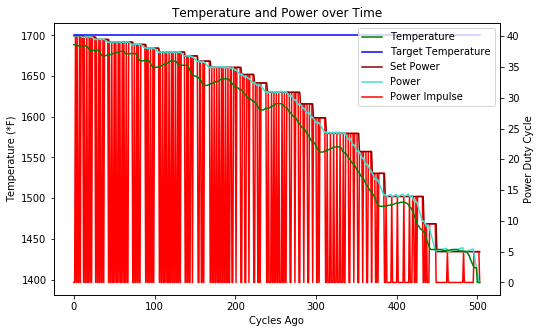

None

Observer will start rendering in 144 cycles
Observer will start rendering in 134 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:43:33.097487 | cycle: 528        | temperature: 1689.35    | target: 1700       | power: 40.277778  | powerOn: 1          | setPower: 40.517531  | haltPowerChange: 542        | powerStep: 0.1775     | slope: 0.12273718 | accel: -0.010829751 | cyclesUntilTarget: 87         | error: 10.65      | percentError: 0.62647059 | realCycleTime: 1.038805   | lastTemperature: 1681.7    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:43:33.785967 | cycle: 529        | temperature: 1689.35    | target: 1700       | power: 40.3698    | powerOn: 1          | setPower: 40.517531  | haltPowerChange: 542        | powerStep: 0.1775     | slope: 0.12777446 | accel: -0.018790362 | cyclesUntilTarget: 83         | error: 10.65      | percentError: 0.62647059 | realCycleTime: 0.997852   | lastTemperature: 1681.7    
Holding power constant
Energizing
T

Tuning: Kiln=timestamp: 2021-10-05 15:43:44.385162 | cycle: 545        | temperature: 1692.05    | target: 1700       | power: 40.601504  | powerOn: 1          | setPower: 40.705652  | haltPowerChange: 558        | powerStep: 0.1325     | slope: 0.12774121 | accel: -0.075483442 | cyclesUntilTarget: 62         | error: 7.95       | percentError: 0.46764706 | realCycleTime: 0.645837   | lastTemperature: 1687.1    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:43:45.021524 | cycle: 546        | temperature: 1692.05    | target: 1700       | power: 40.690691  | powerOn: 1          | setPower: 40.705652  | haltPowerChange: 558        | powerStep: 0.1325     | slope: 0.13009889 | accel: -0.082790203 | cyclesUntilTarget: 61         | error: 7.95       | percentError: 0.46764706 | realCycleTime: 0.634133   | lastTemperature: 1687.1    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:43:45.666412 | cycle: 547        | temperature: 1692.05    | t

Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:43:55.990460 | cycle: 563        | temperature: 1693.85    | target: 1700       | power: 40.849195  | powerOn: 0          | setPower: 40.805652  | haltPowerChange: 574        | powerStep: 0.1025     | slope: 0.1864208  | accel: -0.0233026 | cyclesUntilTarget: 33         | error: 6.15       | percentError: 0.36176471 | realCycleTime: 0.643705   | lastTemperature: 1686.65   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:43:56.628428 | cycle: 564        | temperature: 1693.85    | target: 1700       | power: 40.789474  | powerOn: 1          | setPower: 40.805652  | haltPowerChange: 574        | powerStep: 0.1025     | slope: 0.18936435 | accel: -0.011835272 | cyclesUntilTarget: 32         | error: 6.15       | percentError: 0.36176471 | realCycleTime: 0.633699   | lastTemperature: 1686.65   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:43:57.266101 | cycle: 565     

Observer will start rendering in 74 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:44:07.639236 | cycle: 581        | temperature: 1693.85    | target: 1700       | power: 40.941512  | powerOn: 1          | setPower: 40.963309  | haltPowerChange: 590        | powerStep: 0.1025     | slope: 0.11649653 | accel: -0.0058248265 | cyclesUntilTarget: 53         | error: 6.15       | percentError: 0.36176471 | realCycleTime: 0.643796   | lastTemperature: 1689.35   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:44:08.274562 | cycle: 582        | temperature: 1693.85    | target: 1700       | power: 41.025641  | powerOn: 0          | setPower: 40.963309  | haltPowerChange: 590        | powerStep: 0.1025     | slope: 0.11536456 | accel: -0.005768228 | cyclesUntilTarget: 53         | error: 6.15       | percentError: 0.36176471 | realCycleTime: 0.650113   | lastTemperature: 1689.35   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:44:08.9

Tuning: Kiln=timestamp: 2021-10-05 15:44:18.584894 | cycle: 598        | temperature: 1695.65    | target: 1700       | power: 41.086351  | powerOn: 0          | setPower: 41.063309  | haltPowerChange: 606        | powerStep: 0.1        | slope: 0.094586648 | accel: -0.035469993 | cyclesUntilTarget: 46         | error: 4.35       | percentError: 0.25588235 | realCycleTime: 0.634339   | lastTemperature: 1692.05   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:44:19.215028 | cycle: 599        | temperature: 1695.65    | target: 1700       | power: 41.029207  | powerOn: 1          | setPower: 41.063309  | haltPowerChange: 606        | powerStep: 0.1        | slope: 0.09421859 | accel: -0.029443309 | cyclesUntilTarget: 46         | error: 4.35       | percentError: 0.25588235 | realCycleTime: 0.636817   | lastTemperature: 1692.05   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:44:19.848757 | cycle: 600        | temperature: 1695.65    | 

Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:44:30.180529 | cycle: 616        | temperature: 1694.75    | target: 1700       | power: 41.304348  | powerOn: 0          | setPower: 41.227923  | haltPowerChange: 622        | powerStep: 0.1        | slope: 0.023628336 | accel: -0.053163755 | cyclesUntilTarget: 222        | error: 5.25       | percentError: 0.30882353 | realCycleTime: 0.634831   | lastTemperature: 1693.85   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:44:30.844741 | cycle: 617        | temperature: 1694.75    | target: 1700       | power: 41.248304  | powerOn: 0          | setPower: 41.227923  | haltPowerChange: 622        | powerStep: 0.1        | slope: 0.011578344 | accel: -0.05210255 | cyclesUntilTarget: 453        | error: 5.25       | percentError: 0.30882353 | realCycleTime: 0.647761   | lastTemperature: 1694.3    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:44:31.476810 | cycle: 618  

Tuning: Kiln=timestamp: 2021-10-05 15:44:41.180126 | cycle: 633        | temperature: 1698.35    | target: 1700       | power: 41.301461  | powerOn: 1          | setPower: 41.327923  | haltPowerChange: 638        | powerStep: 0.1        | slope: 0.094814141 | accel: 0.0059258838 | cyclesUntilTarget: 17         | error: 1.65       | percentError: 0.097058824 | realCycleTime: 0.632817   | lastTemperature: 1694.75   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:44:41.816816 | cycle: 634        | temperature: 1698.35    | target: 1700       | power: 41.37931   | powerOn: 0          | setPower: 41.327923  | haltPowerChange: 638        | powerStep: 0.1        | slope: 0.082257974 | accel: 0.0        | cyclesUntilTarget: 20         | error: 1.65       | percentError: 0.097058824 | realCycleTime: 0.638236   | lastTemperature: 1695.2    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:44:42.452243 | cycle: 635        | temperature: 1698.35    |

Tuning: Kiln=timestamp: 2021-10-05 15:44:52.429953 | cycle: 650        | temperature: 1700.6     | target: 1700       | power: 41.428571  | powerOn: 0          | setPower: 0          | haltPowerChange: 654        | powerStep: 0.1        | slope: 0.11230143 | accel: 0.056150715 | cyclesUntilTarget: 99999      | error: -0.6       | percentError: -0.035294118 | realCycleTime: 0.73463    | lastTemperature: 1695.65   
Hard Power Cutoff
Holding power constant
Observer will start rendering in 4 cycles
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:44:53.191330 | cycle: 651        | temperature: 1700.6     | target: 1700       | power: 41.374838  | powerOn: 0          | setPower: 0          | haltPowerChange: 654        | powerStep: 0.1        | slope: 0.11150939 | accel: 0.055754696 | cyclesUntilTarget: 99999      | error: -0.6       | percentError: -0.035294118 | realCycleTime: 0.739848   | lastTemperature: 1695.65   
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timesta

Tuning: Kiln=timestamp: 2021-10-05 15:45:05.366823 | cycle: 667        | temperature: 1686.2     | target: 1700       | power: 41.168996  | powerOn: 0          | setPower: 41.155341  | haltPowerChange: 672        | powerStep: 0.23       | slope: -0.18998556 | accel: -0.12999012 | cyclesUntilTarget: 99999      | error: 13.8       | percentError: 0.81176471 | realCycleTime: 0.750057   | lastTemperature: 1694.75   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:45:06.104600 | cycle: 668        | temperature: 1686.65    | target: 1700       | power: 41.116751  | powerOn: 1          | setPower: 41.155341  | haltPowerChange: 672        | powerStep: 0.2225     | slope: -0.19404599 | accel: -0.13276831 | cyclesUntilTarget: 99999      | error: 13.35      | percentError: 0.78529412 | realCycleTime: 0.734362   | lastTemperature: 1695.2    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:45:06.837007 | cycle: 669        | temperature: 1686.65    | t

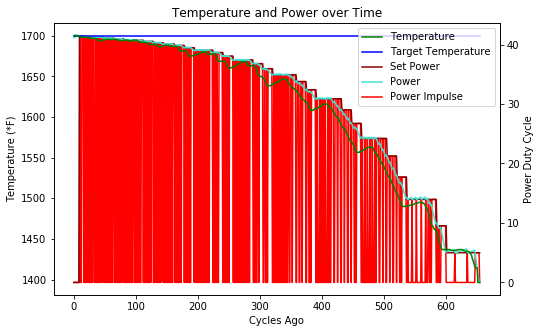

None

Observer will start rendering in 145 cycles
Observer will start rendering in 135 cycles
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:45:15.292080 | cycle: 680        | temperature: 1688.9     | target: 1700       | power: 41.375     | powerOn: 0          | setPower: 41.370341  | haltPowerChange: 688        | powerStep: 0.185      | slope: -0.19691622 | accel: -0.12955015 | cyclesUntilTarget: 99999      | error: 11.1       | percentError: 0.65294118 | realCycleTime: 0.723658   | lastTemperature: 1697.45   
Holding power constant
Observer will start rendering in 125 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:45:15.947542 | cycle: 681        | temperature: 1691.15    | target: 1700       | power: 41.323346  | powerOn: 1          | setPower: 41.370341  | haltPowerChange: 688        | powerStep: 0.1475     | slope: -0.11037539 | accel: -0.078839566 | cyclesUntilTarget: 99999      | error: 8.85       | percentError: 0.52058824 | realCycleTime: 0.951299   | lastTemperature: 1

Tuning: Kiln=timestamp: 2021-10-05 15:45:26.211936 | cycle: 697        | temperature: 1695.2     | target: 1700       | power: 41.493268  | powerOn: 1          | setPower: 41.509147  | haltPowerChange: 704        | powerStep: 0.1        | slope: -0.094194037 | accel: -0.082419782 | cyclesUntilTarget: 99999      | error: 4.8        | percentError: 0.28235294 | realCycleTime: 0.636983   | lastTemperature: 1698.8    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:45:26.846764 | cycle: 698        | temperature: 1696.55    | target: 1700       | power: 41.564792  | powerOn: 0          | setPower: 41.509147  | haltPowerChange: 704        | powerStep: 0.1        | slope: -0.094137287 | accel: -0.058835804 | cyclesUntilTarget: 99999      | error: 3.45       | percentError: 0.20294118 | realCycleTime: 0.637367   | lastTemperature: 1700.15   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:45:27.485353 | cycle: 699        | temperature: 1696.55   

Tuning: Kiln=timestamp: 2021-10-05 15:45:37.876451 | cycle: 714        | temperature: 1699.25    | target: 1700       | power: 41.606715  | powerOn: 0          | setPower: 0          | haltPowerChange: 720        | powerStep: 0.1        | slope: 0.27939276 | accel: 0.24567294 | cyclesUntilTarget: 3          | error: 0.75       | percentError: 0.044117647 | realCycleTime: 0.778474   | lastTemperature: 1686.2    
Preemptively Cutting Power
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:45:38.666664 | cycle: 715        | temperature: 1699.25    | target: 1700       | power: 41.556886  | powerOn: 0          | setPower: 0          | haltPowerChange: 720        | powerStep: 0.1        | slope: 0.27825041 | accel: 0.24466847 | cyclesUntilTarget: 3          | error: 0.75       | percentError: 0.044117647 | realCycleTime: 0.78167    | lastTemperature: 1686.2    
Preemptively Cutting Power
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:45:39.3950

Tuning: Kiln=timestamp: 2021-10-05 15:45:49.570628 | cycle: 731        | temperature: 1677.2     | target: 1700       | power: 41.245593  | powerOn: 1          | setPower: 41.254048  | haltPowerChange: 741        | powerStep: 0.38       | slope: -0.36063845 | accel: -0.12796848 | cyclesUntilTarget: 99999      | error: 22.8       | percentError: 1.3411765  | realCycleTime: 0.64469    | lastTemperature: 1691.15   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:45:50.212039 | cycle: 732        | temperature: 1677.2     | target: 1700       | power: 41.314554  | powerOn: 0          | setPower: 41.254048  | haltPowerChange: 741        | powerStep: 0.38       | slope: -0.40216274 | accel: -0.15081103 | cyclesUntilTarget: 99999      | error: 22.8       | percentError: 1.3411765  | realCycleTime: 0.67137    | lastTemperature: 1693.4    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:45:50.836116 | cycle: 733        | temperature: 1677.2     | t

Tuning: Kiln=timestamp: 2021-10-05 15:46:01.162255 | cycle: 749        | temperature: 1686.2     | target: 1700       | power: 41.542002  | powerOn: 1          | setPower: 41.566804  | haltPowerChange: 757        | powerStep: 0.23       | slope: -0.27436435 | accel: -0.17296883 | cyclesUntilTarget: 99999      | error: 13.8       | percentError: 0.81176471 | realCycleTime: 0.628726   | lastTemperature: 1696.55   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:46:01.796812 | cycle: 750        | temperature: 1687.55    | target: 1700       | power: 41.609195  | powerOn: 0          | setPower: 41.566804  | haltPowerChange: 757        | powerStep: 0.2075     | slope: -0.24409863 | accel: -0.18016803 | cyclesUntilTarget: 99999      | error: 12.45      | percentError: 0.73235294 | realCycleTime: 0.645231   | lastTemperature: 1697.0    
Holding power constant
Observer will start rendering in 55 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:46:02.437585 | cycl

Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:46:12.801715 | cycle: 767        | temperature: 1697.45    | target: 1700       | power: 41.713641  | powerOn: 0          | setPower: 41.671754  | haltPowerChange: 773        | powerStep: 0.1        | slope: -0.046770278 | accel: 0.023385139 | cyclesUntilTarget: 99999      | error: 2.55       | percentError: 0.15       | realCycleTime: 0.641433   | lastTemperature: 1699.25   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:46:13.452000 | cycle: 768        | temperature: 1697.45    | target: 1700       | power: 41.666667  | powerOn: 1          | setPower: 41.671754  | haltPowerChange: 773        | powerStep: 0.1        | slope: -0.045922186 | accel: 0.045922186 | cyclesUntilTarget: 99999      | error: 2.55       | percentError: 0.15       | realCycleTime: 0.653279   | lastTemperature: 1699.25   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:46:14.095496 | cycle: 769 

Tuning: Kiln=timestamp: 2021-10-05 15:46:24.730337 | cycle: 784        | temperature: 1692.5     | target: 1700       | power: 41.261062  | powerOn: 0          | setPower: 0          | haltPowerChange: 773        | powerStep: 0.125      | slope: 0.34686846 | accel: 0.28565638 | cyclesUntilTarget: 22         | error: 7.5        | percentError: 0.44117647 | realCycleTime: 0.735149   | lastTemperature: 1677.2    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:46:25.370029 | cycle: 785        | temperature: 1691.15    | target: 1700       | power: 41.21547   | powerOn: 0          | setPower: 0          | haltPowerChange: 773        | powerStep: 0.1475     | slope: 0.36295176 | accel: 0.31026521 | cyclesUntilTarget: 24         | error: 8.85       | percentError: 0.52058824 | realCycleTime: 0.640581   | lastTemperature: 1677.2    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:46:26.017891 | cycle: 786        | temperature: 1689.35    | targe

Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:46:36.446572 | cycle: 802        | temperature: 1683.5     | target: 1700       | power: 41.32321   | powerOn: 0          | setPower: 41.286511  | haltPowerChange: 805        | powerStep: 0.275      | slope: -0.20261022 | accel: -0.090048987 | cyclesUntilTarget: 99999      | error: 16.5       | percentError: 0.97058824 | realCycleTime: 0.666304   | lastTemperature: 1691.6    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:46:37.086218 | cycle: 803        | temperature: 1684.4     | target: 1700       | power: 41.27844   | powerOn: 1          | setPower: 41.286511  | haltPowerChange: 805        | powerStep: 0.26       | slope: -0.24456028 | accel: -0.093165821 | cyclesUntilTarget: 99999      | error: 15.6       | percentError: 0.91764706 | realCycleTime: 0.644013   | lastTemperature: 1693.85   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:46:37.719046 | cycle: 804        | temperature: 1

Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:46:49.487025 | cycle: 820        | temperature: 1699.7     | target: 1700       | power: 41.489362  | powerOn: 0          | setPower: 0          | haltPowerChange: 821        | powerStep: 0.1        | slope: 0.035119142 | accel: -0.16242603 | cyclesUntilTarget: 9          | error: 0.3        | percentError: 0.017647059 | realCycleTime: 0.854235   | lastTemperature: 1697.9    
Preemptively Cutting Power
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:46:50.336815 | cycle: 821        | temperature: 1699.7     | target: 1700       | power: 41.445271  | powerOn: 0          | setPower: 0          | haltPowerChange: 821        | powerStep: 0.1        | slope: 0.035070328 | accel: -0.17535164 | cyclesUntilTarget: 9          | error: 0.3        | percentError: 0.017647059 | realCycleTime: 0.855424   | lastTemperature: 1697.9    
Preemptively Cutting Power
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-0

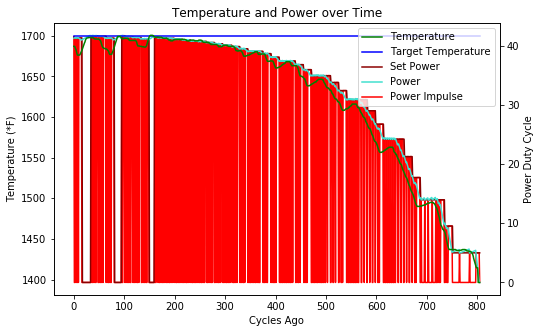

None

Observer will start rendering in 146 cycles
Observer will start rendering in 136 cycles
Observer will start rendering in 126 cycles
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:47:00.130488 | cycle: 833        | temperature: 1688.9     | target: 1700       | power: 41.343127  | powerOn: 0          | setPower: 41.326216  | haltPowerChange: 841        | powerStep: 0.185      | slope: -0.13632112 | accel: 0.0        | cyclesUntilTarget: 99999      | error: 11.1       | percentError: 0.65294118 | realCycleTime: 0.715223   | lastTemperature: 1694.75   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:47:00.765458 | cycle: 834        | temperature: 1688.9     | target: 1700       | power: 41.29979   | powerOn: 1          | setPower: 41.326216  | haltPowerChange: 841        | powerStep: 0.185      | slope: -0.061550582 | accel: 0.034622203 | cyclesUntilTarget: 99999      | error: 11.1       | percentError: 0.65294118 | realCycleTime: 0.974808   | lastTemperature: 16

Tuning: Kiln=timestamp: 2021-10-05 15:47:10.995072 | cycle: 850        | temperature: 1690.7     | target: 1700       | power: 41.340206  | powerOn: 0          | setPower: 41.326216  | haltPowerChange: 841        | powerStep: 0.155      | slope: 0.32109372 | accel: 0.24973956 | cyclesUntilTarget: 29         | error: 9.3        | percentError: 0.54705882 | realCycleTime: 0.630657   | lastTemperature: 1678.55   
Holding power constant
Observer will start rendering in 106 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:47:11.641739 | cycle: 851        | temperature: 1691.15    | target: 1700       | power: 41.297631  | powerOn: 1          | setPower: 41.326216  | haltPowerChange: 841        | powerStep: 0.1475     | slope: 0.27130277 | accel: 0.22411968 | cyclesUntilTarget: 33         | error: 8.85       | percentError: 0.52058824 | realCycleTime: 0.635821   | lastTemperature: 1680.8    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:47:12.285272 | cycle: 

Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:47:22.624480 | cycle: 868        | temperature: 1698.8     | target: 1700       | power: 41.497976  | powerOn: 0          | setPower: 41.458716  | haltPowerChange: 873        | powerStep: 0.1        | slope: 0.0        | accel: 0.029345019 | cyclesUntilTarget: 99999      | error: 1.2        | percentError: 0.070588235 | realCycleTime: 0.63895    | lastTemperature: 1698.8    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:47:23.256293 | cycle: 869        | temperature: 1698.8     | target: 1700       | power: 41.456016  | powerOn: 1          | setPower: 41.458716  | haltPowerChange: 873        | powerStep: 0.1        | slope: -0.023812926 | accel: 0.047625851 | cyclesUntilTarget: 99999      | error: 1.2        | percentError: 0.070588235 | realCycleTime: 0.62991    | lastTemperature: 1699.7    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:47:23.884180 | cycle: 870        | temperature: 1

Tuning: Kiln=timestamp: 2021-10-05 15:47:34.646745 | cycle: 885        | temperature: 1700.15    | target: 1700       | power: 41.19403   | powerOn: 0          | setPower: 0          | haltPowerChange: 889        | powerStep: 0.1        | slope: 0.24495427 | accel: -0.029394512 | cyclesUntilTarget: 99999      | error: -0.15      | percentError: -0.0088235294 | realCycleTime: 0.765449   | lastTemperature: 1688.9    
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:47:35.399041 | cycle: 886        | temperature: 1698.35    | target: 1700       | power: 41.153082  | powerOn: 0          | setPower: 0          | haltPowerChange: 889        | powerStep: 0.1        | slope: 0.20497964 | accel: -0.048804676 | cyclesUntilTarget: 8          | error: 1.65       | percentError: 0.097058824 | realCycleTime: 0.768369   | lastTemperature: 1688.9    
Preemptively Cutting Power
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:47:36.183543 

Tuning: Kiln=timestamp: 2021-10-05 15:47:46.124724 | cycle: 902        | temperature: 1686.2     | target: 1700       | power: 41.193738  | powerOn: 0          | setPower: 41.137599  | haltPowerChange: 905        | powerStep: 0.23       | slope: -0.12653607 | accel: -0.097777873 | cyclesUntilTarget: 99999      | error: 13.8       | percentError: 0.81176471 | realCycleTime: 0.651988   | lastTemperature: 1691.15   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:47:46.755450 | cycle: 903        | temperature: 1687.55    | target: 1700       | power: 41.15347   | powerOn: 0          | setPower: 41.137599  | haltPowerChange: 905        | powerStep: 0.2075     | slope: -0.095430319 | accel: -0.059643949 | cyclesUntilTarget: 99999      | error: 12.45      | percentError: 0.73235294 | realCycleTime: 0.628731   | lastTemperature: 1691.15   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:47:47.405825 | cycle: 904        | temperature: 1687.55    

Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:47:57.674112 | cycle: 920        | temperature: 1699.25    | target: 1700       | power: 41.346154  | powerOn: 0          | setPower: 41.322599  | haltPowerChange: 921        | powerStep: 0.1        | slope: 0.0        | accel: -0.12497818 | cyclesUntilTarget: 99999      | error: 0.75       | percentError: 0.044117647 | realCycleTime: 0.63011    | lastTemperature: 1699.25   
Holding power constant
Observer will start rendering in 36 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:47:58.329689 | cycle: 921        | temperature: 1699.25    | target: 1700       | power: 41.306436  | powerOn: 1          | setPower: 41.322599  | haltPowerChange: 921        | powerStep: 0.1        | slope: 0.0        | accel: -0.15468088 | cyclesUntilTarget: 99999      | error: 0.75       | percentError: 0.044117647 | realCycleTime: 0.63033    | lastTemperature: 1699.25   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:47:58.96

Tuning: Kiln=timestamp: 2021-10-05 15:48:09.495289 | cycle: 937        | temperature: 1702.85    | target: 1700       | power: 41.15421   | powerOn: 0          | setPower: 0          | haltPowerChange: 937        | powerStep: 0.1        | slope: 0.14072426 | accel: 0.14575013 | cyclesUntilTarget: 99999      | error: -2.85      | percentError: -0.16764706 | realCycleTime: 0.74614    | lastTemperature: 1696.55   
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:48:10.234014 | cycle: 938        | temperature: 1701.05    | target: 1700       | power: 41.115312  | powerOn: 0          | setPower: 0          | haltPowerChange: 937        | powerStep: 0.1        | slope: 0.14111613 | accel: 0.146156   | cyclesUntilTarget: 99999      | error: -1.05      | percentError: -0.061764706 | realCycleTime: 0.744068   | lastTemperature: 1694.75   
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:48:10.960508 | cycle: 939  

Tuning: Kiln=timestamp: 2021-10-05 15:48:20.774812 | cycle: 954        | temperature: 1675.4     | target: 1700       | power: 40.968343  | powerOn: 1          | setPower: 41.027837  | haltPowerChange: 963        | powerStep: 0.41       | slope: -0.31137702 | accel: -0.17875348 | cyclesUntilTarget: 99999      | error: 24.6       | percentError: 1.4470588  | realCycleTime: 0.650337   | lastTemperature: 1687.55   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:48:21.400457 | cycle: 955        | temperature: 1675.4     | target: 1700       | power: 41.023256  | powerOn: 1          | setPower: 41.027837  | haltPowerChange: 963        | powerStep: 0.41       | slope: -0.35753785 | accel: -0.20856375 | cyclesUntilTarget: 99999      | error: 24.6       | percentError: 1.4470588  | realCycleTime: 0.629304   | lastTemperature: 1688.9    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:48:22.034906 | cycle: 956        | temperature: 1675.4     | t

Tuning: Kiln=timestamp: 2021-10-05 15:48:33.796795 | cycle: 972        | temperature: 1689.8     | target: 1700       | power: 41.208791  | powerOn: 1          | setPower: 41.244161  | haltPowerChange: 979        | powerStep: 0.17       | slope: -0.21582379 | accel: -0.14902119 | cyclesUntilTarget: 99999      | error: 10.2       | percentError: 0.6        | realCycleTime: 0.729762   | lastTemperature: 1699.25   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:48:34.536796 | cycle: 973        | temperature: 1694.3     | target: 1700       | power: 41.26258   | powerOn: 0          | setPower: 41.244161  | haltPowerChange: 979        | powerStep: 0.1        | slope: -0.11147956 | accel: -0.096277799 | cyclesUntilTarget: 99999      | error: 5.7        | percentError: 0.33529412 | realCycleTime: 0.740046   | lastTemperature: 1699.25   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:48:35.287074 | cycle: 974        | temperature: 1697.0     | 

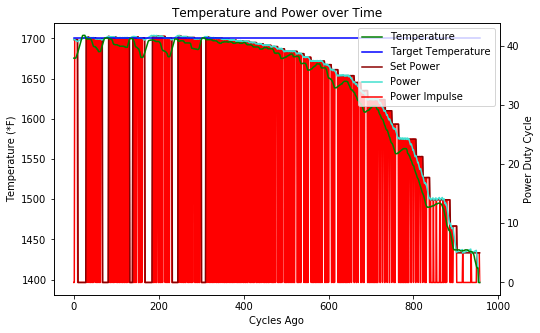

None

Observer will start rendering in 147 cycles
Observer will start rendering in 137 cycles
Observer will start rendering in 127 cycles
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:48:43.108740 | cycle: 983        | temperature: 1700.6     | target: 1700       | power: 41.06981   | powerOn: 0          | setPower: 0          | haltPowerChange: 979        | powerStep: 0.1        | slope: -0.061386995 | accel: -0.083310922 | cyclesUntilTarget: -9         | error: -0.6       | percentError: -0.035294118 | realCycleTime: 0.85523    | lastTemperature: 1703.75   
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:48:43.845681 | cycle: 984        | temperature: 1700.6     | target: 1700       | power: 41.032609  | powerOn: 0          | setPower: 0          | haltPowerChange: 979        | powerStep: 0.1        | slope: -0.045293333 | accel: -0.058234285 | cyclesUntilTarget: -12        | error: -0.6       | percentError: -0.035294118 | realCycleTime: 1.1591

Tuning: Kiln=timestamp: 2021-10-05 15:48:54.336410 | cycle: 1000       | temperature: 1688.9     | target: 1700       | power: 41.071429  | powerOn: 0          | setPower: 41.058409  | haltPowerChange: 1001       | powerStep: 0.185      | slope: 0.26417161 | accel: 0.2221443  | cyclesUntilTarget: 42         | error: 11.1       | percentError: 0.65294118 | realCycleTime: 0.624594   | lastTemperature: 1679.0    
Holding power constant
Observer will start rendering in 107 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:48:54.994794 | cycle: 1001       | temperature: 1688.9     | target: 1700       | power: 41.03479   | powerOn: 1          | setPower: 41.058409  | haltPowerChange: 1001       | powerStep: 0.185      | slope: 0.29511711 | accel: 0.20658198 | cyclesUntilTarget: 38         | error: 11.1       | percentError: 0.65294118 | realCycleTime: 0.635341   | lastTemperature: 1677.65   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:48:55.634742 | cycle: 

Tuning: Kiln=timestamp: 2021-10-05 15:49:05.855451 | cycle: 1018       | temperature: 1692.05    | target: 1700       | power: 41.036907  | powerOn: 1          | setPower: 41.058409  | haltPowerChange: 1001       | powerStep: 0.1325     | slope: 0.081820052 | accel: 0.029221447 | cyclesUntilTarget: 97         | error: 7.95       | percentError: 0.46764706 | realCycleTime: 0.641652   | lastTemperature: 1688.9    
Adding Energy
Tuned power to 41.19090867992767
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:49:06.605650 | cycle: 1019       | temperature: 1692.5     | target: 1700       | power: 41.088674  | powerOn: 1          | setPower: 41.190909  | haltPowerChange: 1033       | powerStep: 0.125      | slope: 0.081570948 | accel: 0.03568729 | cyclesUntilTarget: 92         | error: 7.5        | percentError: 0.44117647 | realCycleTime: 0.735556   | lastTemperature: 1688.9    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:49:07.245398 | cycle: 1020       | temp

Tuning: Kiln=timestamp: 2021-10-05 15:49:16.954202 | cycle: 1035       | temperature: 1699.7     | target: 1700       | power: 41.212121  | powerOn: 1          | setPower: 41.290909  | haltPowerChange: 1049       | powerStep: 0.1        | slope: -0.01007948 | accel: 0.00503974 | cyclesUntilTarget: 99999      | error: 0.3        | percentError: 0.017647059 | realCycleTime: 0.744086   | lastTemperature: 1700.15   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:49:17.585379 | cycle: 1036       | temperature: 1699.7     | target: 1700       | power: 41.262976  | powerOn: 1          | setPower: 41.290909  | haltPowerChange: 1049       | powerStep: 0.1        | slope: 0.047640372 | accel: 0.011910093 | cyclesUntilTarget: 6          | error: 0.3        | percentError: 0.017647059 | realCycleTime: 0.629718   | lastTemperature: 1697.9    
Preemptively Cutting Power
Tuned power to 0
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:49:18.319609 | cycle: 1037       | tempe

Tuning: Kiln=timestamp: 2021-10-05 15:49:29.118124 | cycle: 1052       | temperature: 1688.9     | target: 1700       | power: 40.870307  | powerOn: 1          | setPower: 40.972201  | haltPowerChange: 1065       | powerStep: 0.185      | slope: -0.011296984 | accel: -0.062133413 | cyclesUntilTarget: 99999      | error: 11.1       | percentError: 0.65294118 | realCycleTime: 0.663894   | lastTemperature: 1689.35   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:49:29.763891 | cycle: 1053       | temperature: 1687.1     | target: 1700       | power: 40.920716  | powerOn: 1          | setPower: 40.972201  | haltPowerChange: 1065       | powerStep: 0.215      | slope: -0.070274069 | accel: -0.093698758 | cyclesUntilTarget: 99999      | error: 12.9       | percentError: 0.75882353 | realCycleTime: 0.64035    | lastTemperature: 1689.8    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:49:30.408068 | cycle: 1054       | temperature: 1685.75   

Tuning: Kiln=timestamp: 2021-10-05 15:49:41.515959 | cycle: 1070       | temperature: 1689.8     | target: 1700       | power: 41.092437  | powerOn: 1          | setPower: 41.155578  | haltPowerChange: 1081       | powerStep: 0.17       | slope: -0.069951159 | accel: -0.023317053 | cyclesUntilTarget: 99999      | error: 10.2       | percentError: 0.6        | realCycleTime: 0.643306   | lastTemperature: 1692.5    
Holding power constant
Observer will start rendering in 37 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:49:42.159225 | cycle: 1071       | temperature: 1690.25    | target: 1700       | power: 41.141898  | powerOn: 1          | setPower: 41.155578  | haltPowerChange: 1081       | powerStep: 0.1625     | slope: -0.058721469 | accel: -0.017616441 | cyclesUntilTarget: 99999      | error: 9.75       | percentError: 0.57352941 | realCycleTime: 0.638608   | lastTemperature: 1692.5    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:49:42.805950 | 

Tuning: Kiln=timestamp: 2021-10-05 15:49:52.534904 | cycle: 1087       | temperature: 1699.7     | target: 1700       | power: 41.259321  | powerOn: 1          | setPower: 41.281364  | haltPowerChange: 1097       | powerStep: 0.1        | slope: 0.0        | accel: -0.15187129 | cyclesUntilTarget: 99999      | error: 0.3        | percentError: 0.017647059 | realCycleTime: 0.641991   | lastTemperature: 1699.7    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:49:53.175137 | cycle: 1088       | temperature: 1699.7     | target: 1700       | power: 41.307947  | powerOn: 0          | setPower: 41.281364  | haltPowerChange: 1097       | powerStep: 0.1        | slope: 0.0        | accel: -0.11918421 | cyclesUntilTarget: 99999      | error: 0.3        | percentError: 0.017647059 | realCycleTime: 0.629278   | lastTemperature: 1699.7    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:49:53.804034 | cycle: 1089       | temperature: 1700.15    | t

Tuning: Kiln=timestamp: 2021-10-05 15:50:04.626640 | cycle: 1104       | temperature: 1691.15    | target: 1700       | power: 40.849673  | powerOn: 0          | setPower: 0          | haltPowerChange: 1097       | powerStep: 0.1475     | slope: 0.14307971 | accel: 0.11923309 | cyclesUntilTarget: 62         | error: 8.85       | percentError: 0.52058824 | realCycleTime: 0.62902    | lastTemperature: 1685.75   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:50:05.265415 | cycle: 1105       | temperature: 1689.35    | target: 1700       | power: 40.816327  | powerOn: 0          | setPower: 0          | haltPowerChange: 1097       | powerStep: 0.1775     | slope: 0.14175952 | accel: 0.10631964 | cyclesUntilTarget: 75         | error: 10.65      | percentError: 0.62647059 | realCycleTime: 0.634878   | lastTemperature: 1683.95   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:50:05.904823 | cycle: 1106       | temperature: 1687.55    | targe

Tuning: Kiln=timestamp: 2021-10-05 15:50:17.577082 | cycle: 1122       | temperature: 1692.95    | target: 1700       | power: 40.982287  | powerOn: 1          | setPower: 40.984112  | haltPowerChange: 1123       | powerStep: 0.1175     | slope: 0.060222663 | accel: 0.035129887 | cyclesUntilTarget: 117        | error: 7.05       | percentError: 0.41470588 | realCycleTime: 0.747227   | lastTemperature: 1690.25   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:50:18.336827 | cycle: 1123       | temperature: 1692.95    | target: 1700       | power: 41.029767  | powerOn: 0          | setPower: 40.984112  | haltPowerChange: 1123       | powerStep: 0.1175     | slope: 0.060526744 | accel: 0.035307267 | cyclesUntilTarget: 116        | error: 7.05       | percentError: 0.41470588 | realCycleTime: 0.743473   | lastTemperature: 1690.25   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:50:19.077096 | cycle: 1124       | temperature: 1693.85    | t

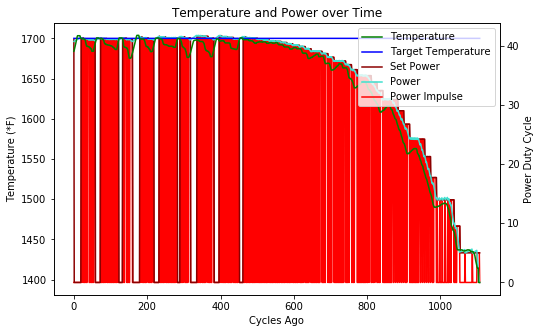

None

Observer will start rendering in 148 cycles
Observer will start rendering in 138 cyclesDepowering

Tuning: Kiln=timestamp: 2021-10-05 15:50:27.520540 | cycle: 1135       | temperature: 1698.8     | target: 1700       | power: 41.115538  | powerOn: 0          | setPower: 41.086612  | haltPowerChange: 1140       | powerStep: 0.1        | slope: -0.020415246 | accel: -0.040830492 | cyclesUntilTarget: 99999      | error: 1.2        | percentError: 0.070588235 | realCycleTime: 0.734745   | lastTemperature: 1699.7    Observer will start rendering in 128 cycles

Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:50:28.218436 | cycle: 1136       | temperature: 1699.25    | target: 1700       | power: 41.082803  | powerOn: 1          | setPower: 41.086612  | haltPowerChange: 1140       | powerStep: 0.1        | slope: -0.0075244771 | accel: -0.02633567 | cyclesUntilTarget: 99999      | error: 0.75       | percentError: 0.044117647 | realCycleTime: 0.996747   | lastTemperatu

Tuning: Kiln=timestamp: 2021-10-05 15:50:39.305974 | cycle: 1152       | temperature: 1703.3     | target: 1700       | power: 41.037736  | powerOn: 0          | setPower: 0          | haltPowerChange: 1156       | powerStep: 0.1        | slope: 0.17016517 | accel: 0.18517975 | cyclesUntilTarget: 99999      | error: -3.3       | percentError: -0.19411765 | realCycleTime: 0.749272   | lastTemperature: 1695.65   
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:50:40.056008 | cycle: 1153       | temperature: 1703.3     | target: 1700       | power: 41.005499  | powerOn: 0          | setPower: 0          | haltPowerChange: 1156       | powerStep: 0.1        | slope: 0.22511983 | accel: 0.22511983 | cyclesUntilTarget: 99999      | error: -3.3       | percentError: -0.19411765 | realCycleTime: 0.732943   | lastTemperature: 1693.4    
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:50:40.784379 | cycle: 1154  

Tuning: Kiln=timestamp: 2021-10-05 15:50:50.824646 | cycle: 1169       | temperature: 1675.85    | target: 1700       | power: 40.574088  | powerOn: 1          | setPower: 40.916941  | haltPowerChange: 1182       | powerStep: 0.4025     | slope: -0.2504301 | accel: -0.071551458 | cyclesUntilTarget: 99999      | error: 24.15      | percentError: 1.4205882  | realCycleTime: 0.628918   | lastTemperature: 1685.3    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:50:51.455597 | cycle: 1170       | temperature: 1674.5     | target: 1700       | power: 40.620155  | powerOn: 1          | setPower: 40.916941  | haltPowerChange: 1182       | powerStep: 0.425      | slope: -0.37794978 | accel: -0.1358257 | cyclesUntilTarget: 99999      | error: 25.5       | percentError: 1.5        | realCycleTime: 0.635005   | lastTemperature: 1688.9    
Holding power constant
Observer will start rendering in 88 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:50:52.114082 | cycle

Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:51:02.446124 | cycle: 1187       | temperature: 1692.95    | target: 1700       | power: 41.086458  | powerOn: 1          | setPower: 41.101941  | haltPowerChange: 1198       | powerStep: 0.1175     | slope: -0.16209632 | accel: -0.040524081 | cyclesUntilTarget: 99999      | error: 7.05       | percentError: 0.41470588 | realCycleTime: 0.647763   | lastTemperature: 1699.25   
Holding power constant
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:51:03.075214 | cycle: 1188       | temperature: 1693.4     | target: 1700       | power: 41.131498  | powerOn: 0          | setPower: 41.101941  | haltPowerChange: 1198       | powerStep: 0.11       | slope: -0.16633294 | accel: -0.059404623 | cyclesUntilTarget: 99999      | error: 6.6        | percentError: 0.38823529 | realCycleTime: 0.631264   | lastTemperature: 1699.7    
Holding power constant
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:51:03.706119 | c

Tuning: Kiln=timestamp: 2021-10-05 15:51:14.548776 | cycle: 1204       | temperature: 1696.1     | target: 1700       | power: 40.785498  | powerOn: 1          | setPower: 40.916327  | haltPowerChange: 1218       | powerStep: 0.1        | slope: -0.16101547 | accel: -0.1358568 | cyclesUntilTarget: 99999      | error: 3.9        | percentError: 0.22941176 | realCycleTime: 0.74527    | lastTemperature: 1703.3    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:51:15.195958 | cycle: 1205       | temperature: 1693.85    | target: 1700       | power: 40.830189  | powerOn: 1          | setPower: 40.916327  | haltPowerChange: 1218       | powerStep: 0.1025     | slope: -0.19976749 | accel: -0.14688786 | cyclesUntilTarget: 99999      | error: 6.15       | percentError: 0.36176471 | realCycleTime: 0.638242   | lastTemperature: 1701.5    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:51:15.826596 | cycle: 1206       | temperature: 1691.6     | ta

Tuning: Kiln=timestamp: 2021-10-05 15:51:26.049143 | cycle: 1222       | temperature: 1690.25    | target: 1700       | power: 40.909091  | powerOn: 1          | setPower: 40.916327  | haltPowerChange: 1218       | powerStep: 0.1625     | slope: 0.4214539  | accel: 0.30754744 | cyclesUntilTarget: 23         | error: 9.75       | percentError: 0.57352941 | realCycleTime: 0.658435   | lastTemperature: 1673.6    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:51:26.689270 | cycle: 1223       | temperature: 1690.25    | target: 1700       | power: 40.95309   | powerOn: 0          | setPower: 40.916327  | haltPowerChange: 1218       | powerStep: 0.1625     | slope: 0.43601842 | accel: 0.34174417 | cyclesUntilTarget: 22         | error: 9.75       | percentError: 0.57352941 | realCycleTime: 0.636441   | lastTemperature: 1673.6    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:51:27.335343 | cycle: 1224       | temperature: 1690.25    | targe

Tuning: Kiln=timestamp: 2021-10-05 15:51:38.275910 | cycle: 1240       | temperature: 1692.5     | target: 1700       | power: 41.102941  | powerOn: 0          | setPower: 41.102642  | haltPowerChange: 1246       | powerStep: 0.125      | slope: -0.11133857 | accel: -0.061236214 | cyclesUntilTarget: 99999      | error: 7.5        | percentError: 0.44117647 | realCycleTime: 0.673621   | lastTemperature: 1697.0    
Holding power constant
Observer will start rendering in 18 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:51:38.978724 | cycle: 1241       | temperature: 1694.3     | target: 1700       | power: 41.072741  | powerOn: 1          | setPower: 41.102642  | haltPowerChange: 1246       | powerStep: 0.1        | slope: -0.12062162 | accel: -0.049345207 | cyclesUntilTarget: 99999      | error: 5.7        | percentError: 0.33529412 | realCycleTime: 0.683957   | lastTemperature: 1699.25   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:51:39.657044 | cy

Tuning: Kiln=timestamp: 2021-10-05 15:51:49.747789 | cycle: 1257       | temperature: 1701.95    | target: 1700       | power: 41.176471  | powerOn: 0          | setPower: 0          | haltPowerChange: 1262       | powerStep: 0.1        | slope: 0.27362683 | accel: 0.015201491 | cyclesUntilTarget: 99999      | error: -1.95      | percentError: -0.11470588 | realCycleTime: 0.740059   | lastTemperature: 1689.8    
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:51:50.484649 | cycle: 1258       | temperature: 1701.95    | target: 1700       | power: 41.146589  | powerOn: 0          | setPower: 0          | haltPowerChange: 1262       | powerStep: 0.1        | slope: 0.32444226 | accel: 0.020277641 | cyclesUntilTarget: 99999      | error: -1.95      | percentError: -0.11470588 | realCycleTime: 0.739731   | lastTemperature: 1687.55   
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:51:51.234670 | cycle: 1259

Tuning: Kiln=timestamp: 2021-10-05 15:52:03.126794 | cycle: 1274       | temperature: 1684.4     | target: 1700       | power: 41.032999  | powerOn: 1          | setPower: 41.038628  | haltPowerChange: 1280       | powerStep: 0.26       | slope: -0.13296258 | accel: -0.071595237 | cyclesUntilTarget: 99999      | error: 15.6       | percentError: 0.91764706 | realCycleTime: 0.733289   | lastTemperature: 1690.25   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:52:03.877019 | cycle: 1275       | temperature: 1685.75    | target: 1700       | power: 41.075269  | powerOn: 0          | setPower: 41.038628  | haltPowerChange: 1280       | powerStep: 0.2375     | slope: -0.10209985 | accel: -0.051049927 | cyclesUntilTarget: 99999      | error: 14.25      | percentError: 0.83823529 | realCycleTime: 0.734575   | lastTemperature: 1690.25   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:52:04.597059 | cycle: 1276       | temperature: 1686.2     |

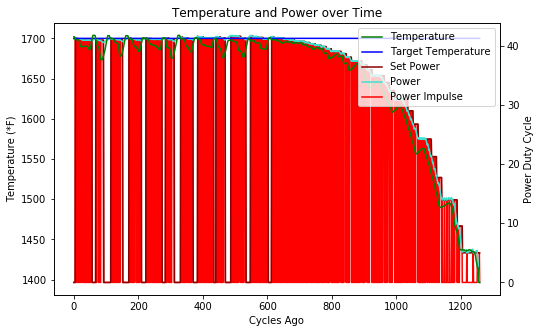

None

Observer will start rendering in 149 cycles
Observer will start rendering in 139 cycles
Observer will start rendering in 129 cyclesEnergizing

Tuning: Kiln=timestamp: 2021-10-05 15:52:13.185034 | cycle: 1287       | temperature: 1687.1     | target: 1700       | power: 41.222459  | powerOn: 1          | setPower: 41.257113  | haltPowerChange: 1296       | powerStep: 0.215      | slope: -0.061412236 | accel: 0.030706118 | cyclesUntilTarget: 99999      | error: 12.9       | percentError: 0.75882353 | realCycleTime: 0.732753   | lastTemperature: 1689.8    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:52:13.848320 | cycle: 1288       | temperature: 1687.55    | target: 1700       | power: 41.264205  | powerOn: 0          | setPower: 41.257113  | haltPowerChange: 1296       | powerStep: 0.2075     | slope: -0.035674398 | accel: 0.024972079 | cyclesUntilTarget: 99999      | error: 12.45      | percentError: 0.73235294 | realCycleTime: 1.051174   | lastTemperature: 

Tuning: Kiln=timestamp: 2021-10-05 15:52:25.075220 | cycle: 1304       | temperature: 1693.4     | target: 1700       | power: 41.011236  | powerOn: 1          | setPower: 41.098594  | haltPowerChange: 1317       | powerStep: 0.11       | slope: -0.14110321 | accel: -0.21165481 | cyclesUntilTarget: 99999      | error: 6.6        | percentError: 0.38823529 | realCycleTime: 0.637831   | lastTemperature: 1698.8    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:52:25.705257 | cycle: 1305       | temperature: 1691.15    | target: 1700       | power: 41.052632  | powerOn: 1          | setPower: 41.098594  | haltPowerChange: 1317       | powerStep: 0.1475     | slope: -0.19924583 | accel: -0.21096618 | cyclesUntilTarget: 99999      | error: 8.85       | percentError: 0.52058824 | realCycleTime: 0.639913   | lastTemperature: 1698.8    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:52:26.340485 | cycle: 1306       | temperature: 1689.35    | t

Tuning: Kiln=timestamp: 2021-10-05 15:52:36.604844 | cycle: 1322       | temperature: 1689.8     | target: 1700       | power: 41.12344   | powerOn: 0          | setPower: 41.098594  | haltPowerChange: 1317       | powerStep: 0.17       | slope: 0.13590855 | accel: 0.10193141 | cyclesUntilTarget: 75         | error: 10.2       | percentError: 0.6        | realCycleTime: 0.66221    | lastTemperature: 1684.4    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:52:37.245960 | cycle: 1323       | temperature: 1689.8     | target: 1700       | power: 41.094941  | powerOn: 1          | setPower: 41.098594  | haltPowerChange: 1317       | powerStep: 0.17       | slope: 0.14169703 | accel: 0.10627277 | cyclesUntilTarget: 72         | error: 10.2       | percentError: 0.6        | realCycleTime: 0.635158   | lastTemperature: 1684.4    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:52:37.875796 | cycle: 1324       | temperature: 1689.8     | targe

Tuning: Kiln=timestamp: 2021-10-05 15:52:48.202368 | cycle: 1340       | temperature: 1692.5     | target: 1700       | power: 41.232877  | powerOn: 1          | setPower: 41.261094  | haltPowerChange: 1348       | powerStep: 0.125      | slope: 0.035384647 | accel: -0.023589765 | cyclesUntilTarget: 212        | error: 7.5        | percentError: 0.44117647 | realCycleTime: 0.635869   | lastTemperature: 1691.15   
Holding power constant
Observer will start rendering in 69 cycles
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:52:48.854680 | cycle: 1341       | temperature: 1694.3     | target: 1700       | power: 41.273101  | powerOn: 0          | setPower: 41.261094  | haltPowerChange: 1348       | powerStep: 0.1        | slope: 0.0        | accel: -0.017601502 | cyclesUntilTarget: 99999      | error: 5.7        | percentError: 0.33529412 | realCycleTime: 0.63915    | lastTemperature: 1694.3    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:52:49.480472 | cyc

Tuning: Kiln=timestamp: 2021-10-05 15:52:59.772439 | cycle: 1357       | temperature: 1689.8     | target: 1700       | power: 40.961408  | powerOn: 0          | setPower: 0          | haltPowerChange: 1348       | powerStep: 0.17       | slope: 0.071512684 | accel: 0.065553294 | cyclesUntilTarget: 143        | error: 10.2       | percentError: 0.6        | realCycleTime: 0.629259   | lastTemperature: 1687.1    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:53:00.415534 | cycle: 1358       | temperature: 1687.55    | target: 1700       | power: 40.933694  | powerOn: 0          | setPower: 0          | haltPowerChange: 1348       | powerStep: 0.2075     | slope: 0.011631081 | accel: 0.0        | cyclesUntilTarget: 1070       | error: 12.45      | percentError: 0.73235294 | realCycleTime: 0.644824   | lastTemperature: 1687.1    
Adding Energy
Tuned power to 41.14119418132612
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:53:01.202449 | cycle: 1359       | temp

Adding Energy
Tuned power to 41.33465863453816
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:53:11.560486 | cycle: 1375       | temperature: 1689.8     | target: 1700       | power: 41.137124  | powerOn: 1          | setPower: 41.334659  | haltPowerChange: 1389       | powerStep: 0.17       | slope: 0.0        | accel: -0.035583233 | cyclesUntilTarget: 99999      | error: 10.2       | percentError: 0.6        | realCycleTime: 0.737707   | lastTemperature: 1689.8    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:53:12.189444 | cycle: 1376       | temperature: 1689.8     | target: 1700       | power: 41.176471  | powerOn: 1          | setPower: 41.334659  | haltPowerChange: 1389       | powerStep: 0.17       | slope: -0.011932434 | accel: -0.047729735 | cyclesUntilTarget: 99999      | error: 10.2       | percentError: 0.6        | realCycleTime: 0.628539   | lastTemperature: 1690.25   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:53

Tuning: Kiln=timestamp: 2021-10-05 15:53:22.996435 | cycle: 1392       | temperature: 1699.25    | target: 1700       | power: 41.203704  | powerOn: 0          | setPower: 0          | haltPowerChange: 1389       | powerStep: 0.1        | slope: 0.050301271 | accel: 0.0        | cyclesUntilTarget: 15         | error: 0.75       | percentError: 0.044117647 | realCycleTime: 0.745508   | lastTemperature: 1697.0    
Adding Energy
Tuned power to 41.303703703703704
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:53:23.740039 | cycle: 1393       | temperature: 1698.35    | target: 1700       | power: 41.176471  | powerOn: 1          | setPower: 41.303704  | haltPowerChange: 1407       | powerStep: 0.1        | slope: -0.02005672 | accel: -0.045127621 | cyclesUntilTarget: 99999      | error: 1.65       | percentError: 0.097058824 | realCycleTime: 0.747879   | lastTemperature: 1699.25   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:53:24.385590 | cycle: 1394       | 

Tuning: Kiln=timestamp: 2021-10-05 15:53:35.039703 | cycle: 1410       | temperature: 1690.7     | target: 1700       | power: 41.30719   | powerOn: 0          | setPower: 41.303704  | haltPowerChange: 1407       | powerStep: 0.155      | slope: 0.16645878 | accel: 0.13316702 | cyclesUntilTarget: 56         | error: 9.3        | percentError: 0.54705882 | realCycleTime: 0.675843   | lastTemperature: 1683.95   
Holding power constant
Observer Rendering KilnDrone
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:53:36.018543 | cycle: 1411       | temperature: 1691.15    | target: 1700       | power: 41.280209  | powerOn: 1          | setPower: 41.303704  | haltPowerChange: 1407       | powerStep: 0.1475     | slope: 0.22311667 | accel: 0.15060375 | cyclesUntilTarget: 40         | error: 8.85       | percentError: 0.52058824 | realCycleTime: 0.672294   | lastTemperature: 1682.15   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:53:37.037343 | cycle: 1412       | te

Tuning: Kiln=timestamp: 2021-10-05 15:53:50.696795 | cycle: 1428       | temperature: 1688.9     | target: 1700       | power: 41.472868  | powerOn: 0          | setPower: 41.464987  | haltPowerChange: 1437       | powerStep: 0.185      | slope: -0.020411162 | accel: -0.1071586 | cyclesUntilTarget: 99999      | error: 11.1       | percentError: 0.65294118 | realCycleTime: 0.734892   | lastTemperature: 1689.8    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:53:51.427059 | cycle: 1429       | temperature: 1689.35    | target: 1700       | power: 41.446094  | powerOn: 1          | setPower: 41.464987  | haltPowerChange: 1437       | powerStep: 0.1775     | slope: -0.010205109 | accel: -0.096948536 | cyclesUntilTarget: 99999      | error: 10.65      | percentError: 0.62647059 | realCycleTime: 0.734926   | lastTemperature: 1689.8    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:53:52.166792 | cycle: 1430       | temperature: 1689.35    |

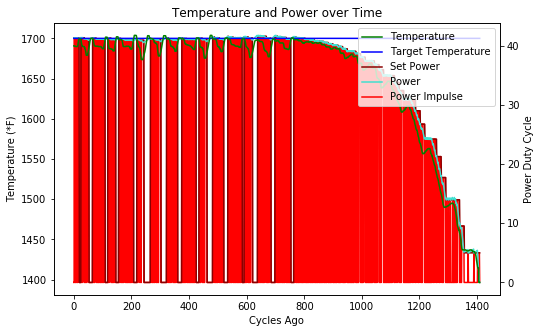

None

Observer will start rendering in 140 cycles
Observer will start rendering in 130 cycles
Observer will start rendering in 120 cycles
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:54:00.694125 | cycle: 1441       | temperature: 1696.1     | target: 1700       | power: 41.575913  | powerOn: 0          | setPower: 41.564987  | haltPowerChange: 1453       | powerStep: 0.1        | slope: -0.072809071 | accel: 0.083210367 | cyclesUntilTarget: 99999      | error: 3.9        | percentError: 0.22941176 | realCycleTime: 0.721064   | lastTemperature: 1699.25   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:54:01.338306 | cycle: 1442       | temperature: 1696.1     | target: 1700       | power: 41.549296  | powerOn: 1          | setPower: 41.564987  | haltPowerChange: 1453       | powerStep: 0.1        | slope: -0.052977219 | accel: 0.056761306 | cyclesUntilTarget: 99999      | error: 3.9        | percentError: 0.22941176 | realCycleTime: 0.990992   | lastTemperature: 

Tuning: Kiln=timestamp: 2021-10-05 15:54:12.475570 | cycle: 1458       | temperature: 1688.0     | target: 1700       | power: 41.444867  | powerOn: 1          | setPower: 41.459593  | haltPowerChange: 1469       | powerStep: 0.2        | slope: -0.058332076 | accel: -0.1516634 | cyclesUntilTarget: 99999      | error: 12.0       | percentError: 0.70588235 | realCycleTime: 0.642871   | lastTemperature: 1690.25   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:54:13.106470 | cycle: 1459       | temperature: 1685.75    | target: 1700       | power: 41.481951  | powerOn: 0          | setPower: 41.459593  | haltPowerChange: 1469       | powerStep: 0.2375     | slope: -0.12891914 | accel: -0.15235899 | cyclesUntilTarget: 99999      | error: 14.25      | percentError: 0.83823529 | realCycleTime: 0.639936   | lastTemperature: 1690.7    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:54:13.731152 | cycle: 1460       | temperature: 1685.3     | t

Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:54:24.095404 | cycle: 1476       | temperature: 1687.1     | target: 1700       | power: 41.666667  | powerOn: 1          | setPower: 41.682093  | haltPowerChange: 1485       | powerStep: 0.215      | slope: -0.046413189 | accel: 0.011603297 | cyclesUntilTarget: 99999      | error: 12.9       | percentError: 0.75882353 | realCycleTime: 0.646368   | lastTemperature: 1688.9    
Holding power constant
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:54:24.739618 | cycle: 1477       | temperature: 1687.55    | target: 1700       | power: 41.703193  | powerOn: 0          | setPower: 41.682093  | haltPowerChange: 1485       | powerStep: 0.2075     | slope: -0.035036305 | accel: 0.017518153 | cyclesUntilTarget: 99999      | error: 12.45      | percentError: 0.73235294 | realCycleTime: 0.642191   | lastTemperature: 1688.9    
Holding power constant
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:54:25.386442 | c

Tuning: Kiln=timestamp: 2021-10-05 15:54:35.173654 | cycle: 1493       | temperature: 1697.45    | target: 1700       | power: 41.785493  | powerOn: 0          | setPower: 41.782093  | haltPowerChange: 1501       | powerStep: 0.1        | slope: 0.034801223 | accel: -0.10440367 | cyclesUntilTarget: 73         | error: 2.55       | percentError: 0.15       | realCycleTime: 0.646529   | lastTemperature: 1696.1    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:54:35.815368 | cycle: 1494       | temperature: 1698.35    | target: 1700       | power: 41.759603  | powerOn: 1          | setPower: 41.782093  | haltPowerChange: 1501       | powerStep: 0.1        | slope: 0.058472967 | accel: -0.07016756 | cyclesUntilTarget: 28         | error: 1.65       | percentError: 0.097058824 | realCycleTime: 0.641322   | lastTemperature: 1696.1    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:54:36.464951 | cycle: 1495       | temperature: 1699.7     | 

Holding power constant
Observer will start rendering in 50 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:54:46.885447 | cycle: 1511       | temperature: 1688.45    | target: 1700       | power: 41.692213  | powerOn: 1          | setPower: 41.71529   | haltPowerChange: 1517       | powerStep: 0.1925     | slope: 0.082379949 | accel: 0.094148513 | cyclesUntilTarget: 140        | error: 11.55      | percentError: 0.67941176 | realCycleTime: 0.637291   | lastTemperature: 1685.3    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:54:47.525483 | cycle: 1512       | temperature: 1688.45    | target: 1700       | power: 41.727941  | powerOn: 0          | setPower: 41.71529   | haltPowerChange: 1517       | powerStep: 0.1925     | slope: 0.079526416 | accel: 0.090887333 | cyclesUntilTarget: 145        | error: 11.55      | percentError: 0.67941176 | realCycleTime: 0.660158   | lastTemperature: 1685.3    
Holding power constant
Energizing
Tuning: Kiln=timestamp:

Tuning: Kiln=timestamp: 2021-10-05 15:54:57.863261 | cycle: 1528       | temperature: 1691.15    | target: 1700       | power: 41.929612  | powerOn: 0          | setPower: 41.902764  | haltPowerChange: 1534       | powerStep: 0.1475     | slope: 0.047072262 | accel: 0.011768066 | cyclesUntilTarget: 188        | error: 8.85       | percentError: 0.52058824 | realCycleTime: 0.637318   | lastTemperature: 1689.35   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:54:58.493027 | cycle: 1529       | temperature: 1692.95    | target: 1700       | power: 41.904184  | powerOn: 0          | setPower: 41.902764  | haltPowerChange: 1534       | powerStep: 0.1175     | slope: 0.047065173 | accel: 0.011766293 | cyclesUntilTarget: 150        | error: 7.05       | percentError: 0.41470588 | realCycleTime: 0.637414   | lastTemperature: 1691.15   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:54:59.123127 | cycle: 1530       | temperature: 1695.2     | t

Tuning: Kiln=timestamp: 2021-10-05 15:55:08.939397 | cycle: 1545       | temperature: 1701.5     | target: 1700       | power: 42.042042  | powerOn: 0          | setPower: 0          | haltPowerChange: 1550       | powerStep: 0.1        | slope: 0.040864363 | accel: 0.035756318 | cyclesUntilTarget: 99999      | error: -1.5       | percentError: -0.088235294 | realCycleTime: 0.734136   | lastTemperature: 1699.7    
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:55:09.685502 | cycle: 1546       | temperature: 1701.95    | target: 1700       | power: 42.016807  | powerOn: 0          | setPower: 0          | haltPowerChange: 1550       | powerStep: 0.1        | slope: 0.050719198 | accel: 0.035503439 | cyclesUntilTarget: 99999      | error: -1.95      | percentError: -0.11470588 | realCycleTime: 0.739365   | lastTemperature: 1699.7    
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:55:10.425812 | cycle: 1

Tuning: Kiln=timestamp: 2021-10-05 15:55:20.825952 | cycle: 1562       | temperature: 1688.0     | target: 1700       | power: 41.973841  | powerOn: 0          | setPower: 41.941004  | haltPowerChange: 1568       | powerStep: 0.2        | slope: -0.011396583 | accel: -0.03988804 | cyclesUntilTarget: 99999      | error: 12.0       | percentError: 0.70588235 | realCycleTime: 0.658092   | lastTemperature: 1688.45   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:55:21.556802 | cycle: 1563       | temperature: 1688.9     | target: 1700       | power: 41.948901  | powerOn: 0          | setPower: 41.941004  | haltPowerChange: 1568       | powerStep: 0.185      | slope: 0.0        | accel: -0.028831405 | cyclesUntilTarget: 99999      | error: 11.1       | percentError: 0.65294118 | realCycleTime: 0.780399   | lastTemperature: 1688.9    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:55:22.280742 | cycle: 1564       | temperature: 1689.8     | 

Tuning: Kiln=timestamp: 2021-10-05 15:55:35.788326 | cycle: 1580       | temperature: 1699.7     | target: 1700       | power: 42.058824  | powerOn: 0          | setPower: 0          | haltPowerChange: 1584       | powerStep: 0.1        | slope: 0.064892702 | accel: 0.035690986 | cyclesUntilTarget: 5          | error: 0.3        | percentError: 0.017647059 | realCycleTime: 1.155754   | lastTemperature: 1695.2    
Preemptively Cutting Power
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:55:36.973955 | cycle: 1581       | temperature: 1699.7     | target: 1700       | power: 42.034098  | powerOn: 0          | setPower: 0          | haltPowerChange: 1584       | powerStep: 0.1        | slope: 0.044337958 | accel: 0.025335976 | cyclesUntilTarget: 7          | error: 0.3        | percentError: 0.017647059 | realCycleTime: 1.184087   | lastTemperature: 1696.55   
Preemptively Cutting Power
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:55:38.

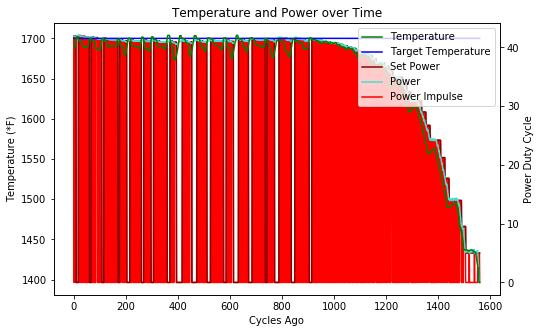

None

Depowering
Observer will start rendering in 141 cyclesTuning: Kiln=timestamp: 2021-10-05 15:55:48.668677 | cycle: 1593       | temperature: 1680.8     | target: 1700       | power: 42.031524  | powerOn: 0          | setPower: 42.010903  | haltPowerChange: 1601       | powerStep: 0.32       | slope: -0.39701715 | accel: -0.21377846 | cyclesUntilTarget: 99999      | error: 19.2       | percentError: 1.1294118  | realCycleTime: 0.736744   | lastTemperature: 1698.35   

Holding power constantObserver will start rendering in 131 cycles

Observer will start rendering in 121 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:55:49.533093 | cycle: 1594       | temperature: 1680.8     | target: 1700       | power: 42.007001  | powerOn: 1          | setPower: 42.010903  | haltPowerChange: 1601       | powerStep: 0.32       | slope: -0.33678637 | accel: -0.17240255 | cyclesUntilTarget: 99999      | error: 19.2       | percentError: 1.1294118  | realCycleTime: 0.935311   | lastTemperature: 16

Tuning: Kiln=timestamp: 2021-10-05 15:55:59.824468 | cycle: 1610       | temperature: 1687.55    | target: 1700       | power: 42.196532  | powerOn: 1          | setPower: 42.281635  | haltPowerChange: 1617       | powerStep: 0.2075     | slope: -0.011716297 | accel: -0.046865188 | cyclesUntilTarget: 99999      | error: 12.45      | percentError: 0.73235294 | realCycleTime: 0.640134   | lastTemperature: 1688.0    
Holding power constant
Observer will start rendering in 101 cycles
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:56:00.481704 | cycle: 1611       | temperature: 1689.8     | target: 1700       | power: 42.229925  | powerOn: 0          | setPower: 42.281635  | haltPowerChange: 1617       | powerStep: 0.17       | slope: 0.047926691 | accel: -0.017972509 | cyclesUntilTarget: 213        | error: 10.2       | percentError: 0.6        | realCycleTime: 0.625956   | lastTemperature: 1688.0    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:56:01.1554

Tuning: Kiln=timestamp: 2021-10-05 15:56:11.544493 | cycle: 1627       | temperature: 1697.45    | target: 1700       | power: 42.129365  | powerOn: 0          | setPower: 0          | haltPowerChange: 1634       | powerStep: 0.1        | slope: 0.03525176 | accel: 0.041127054 | cyclesUntilTarget: 72         | error: 2.55       | percentError: 0.15       | realCycleTime: 0.638266   | lastTemperature: 1696.1    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:56:12.182035 | cycle: 1628       | temperature: 1696.55    | target: 1700       | power: 42.105263  | powerOn: 0          | setPower: 0          | haltPowerChange: 1634       | powerStep: 0.1        | slope: -0.047347663 | accel: 0.047347663 | cyclesUntilTarget: 99999      | error: 3.45       | percentError: 0.20294118 | realCycleTime: 0.633611   | lastTemperature: 1698.35   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:56:12.804836 | cycle: 1629       | temperature: 1694.3     | t

Holding power constant
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:56:23.165459 | cycle: 1645       | temperature: 1674.5     | target: 1700       | power: 42.152975  | powerOn: 0          | setPower: 42.227322  | haltPowerChange: 1650       | powerStep: 0.425      | slope: -0.16553629 | accel: 0.023648041 | cyclesUntilTarget: 99999      | error: 25.5       | percentError: 1.5        | realCycleTime: 0.634302   | lastTemperature: 1680.8    
Holding power constant
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:56:23.805309 | cycle: 1646       | temperature: 1677.2     | target: 1700       | power: 42.129105  | powerOn: 0          | setPower: 42.227322  | haltPowerChange: 1650       | powerStep: 0.38       | slope: -0.1404536 | accel: 0.0        | cyclesUntilTarget: 99999      | error: 22.8       | percentError: 1.3411765  | realCycleTime: 0.640781   | lastTemperature: 1682.6    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:56:24.434890 | cycle

Tuning: Kiln=timestamp: 2021-10-05 15:56:34.184108 | cycle: 1662       | temperature: 1696.1     | target: 1700       | power: 42.424242  | powerOn: 0          | setPower: 42.481025  | haltPowerChange: 1666       | powerStep: 0.1        | slope: 0.10233785 | accel: -0.022741745 | cyclesUntilTarget: 38         | error: 3.9        | percentError: 0.22941176 | realCycleTime: 0.65958    | lastTemperature: 1692.05   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:56:34.820520 | cycle: 1663       | temperature: 1696.1     | target: 1700       | power: 42.400449  | powerOn: 1          | setPower: 42.481025  | haltPowerChange: 1666       | powerStep: 0.1        | slope: 0.059402271 | accel: -0.047521816 | cyclesUntilTarget: 66         | error: 3.9        | percentError: 0.22941176 | realCycleTime: 0.631289   | lastTemperature: 1693.85   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:56:35.452459 | cycle: 1664       | temperature: 1696.1     | 

Tuning: Kiln=timestamp: 2021-10-05 15:56:46.145141 | cycle: 1679       | temperature: 1694.75    | target: 1700       | power: 42.245692  | powerOn: 0          | setPower: 0          | haltPowerChange: 1666       | powerStep: 0.1        | slope: 0.011790302 | accel: 0.17685454 | cyclesUntilTarget: 445        | error: 5.25       | percentError: 0.30882353 | realCycleTime: 0.636116   | lastTemperature: 1694.3    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:56:46.785759 | cycle: 1680       | temperature: 1692.05    | target: 1700       | power: 42.222222  | powerOn: 0          | setPower: 0          | haltPowerChange: 1666       | powerStep: 0.1325     | slope: -0.011754307 | accel: 0.14105168 | cyclesUntilTarget: 99999      | error: 7.95       | percentError: 0.46764706 | realCycleTime: 0.638064   | lastTemperature: 1692.5    
Adding Energy
Tuned power to 42.35472222222222
Observer will start rendering in 31 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05

Tuning: Kiln=timestamp: 2021-10-05 15:56:57.789738 | cycle: 1697       | temperature: 1686.65    | target: 1700       | power: 42.377545  | powerOn: 0          | setPower: 42.354722  | haltPowerChange: 1695       | powerStep: 0.2225     | slope: 0.1757321  | accel: 0.046861893 | cyclesUntilTarget: 76         | error: 13.35      | percentError: 0.78529412 | realCycleTime: 0.640179   | lastTemperature: 1679.9    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:56:58.445981 | cycle: 1698       | temperature: 1686.65    | target: 1700       | power: 42.354235  | powerOn: 1          | setPower: 42.354722  | haltPowerChange: 1695       | powerStep: 0.2225     | slope: 0.10454856 | accel: 0.011616507 | cyclesUntilTarget: 128        | error: 13.35      | percentError: 0.78529412 | realCycleTime: 0.645633   | lastTemperature: 1682.6    
Adding Energy
Tuned power to 42.57722222222222
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:56:59.181761 | cycle: 1699       | tempe

Tuning: Kiln=timestamp: 2021-10-05 15:57:09.047041 | cycle: 1714       | temperature: 1698.8     | target: 1700       | power: 42.584515  | powerOn: 0          | setPower: 42.577222  | haltPowerChange: 1713       | powerStep: 0.1        | slope: 0.056403135 | accel: -0.014100784 | cyclesUntilTarget: 21         | error: 1.2        | percentError: 0.070588235 | realCycleTime: 0.797828   | lastTemperature: 1696.1    
Adding Energy
Tuned power to 42.68451472191931
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:57:09.907088 | cycle: 1715       | temperature: 1698.8     | target: 1700       | power: 42.561308  | powerOn: 1          | setPower: 42.684515  | haltPowerChange: 1729       | powerStep: 0.1        | slope: 0.026523542 | accel: -0.026523542 | cyclesUntilTarget: 45         | error: 1.2        | percentError: 0.070588235 | realCycleTime: 0.848303   | lastTemperature: 1697.45   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:57:10.631580 | cycle: 1716       |

Tuning: Kiln=timestamp: 2021-10-05 15:57:22.772402 | cycle: 1731       | temperature: 1701.05    | target: 1700       | power: 42.517558  | powerOn: 0          | setPower: 0          | haltPowerChange: 1729       | powerStep: 0.1        | slope: 0.22794141 | accel: 0.017533955 | cyclesUntilTarget: 99999      | error: -1.05      | percentError: -0.061764706 | realCycleTime: 0.855483   | lastTemperature: 1689.35   
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:57:23.647082 | cycle: 1732       | temperature: 1698.8     | target: 1700       | power: 42.4946    | powerOn: 0          | setPower: 0          | haltPowerChange: 1729       | powerStep: 0.1        | slope: 0.22625327 | accel: 0.0087020488 | cyclesUntilTarget: 5          | error: 1.2        | percentError: 0.070588235 | realCycleTime: 0.861866   | lastTemperature: 1687.1    
Preemptively Cutting Power
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:57:24.497084 | 

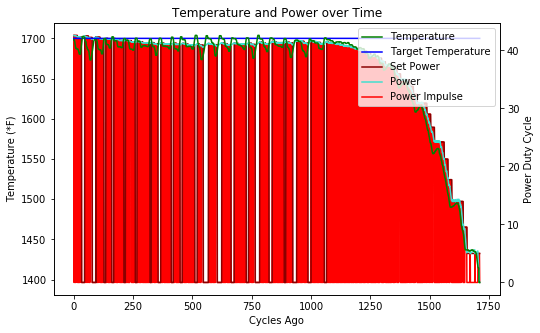

None

Observer will start rendering in 142 cyclesEnergizing

Observer will start rendering in 132 cyclesTuning: Kiln=timestamp: 2021-10-05 15:57:32.188210 | cycle: 1743       | temperature: 1682.15    | target: 1700       | power: 42.565754  | powerOn: 1          | setPower: 42.571668  | haltPowerChange: 1748       | powerStep: 0.2975     | slope: -0.071109401 | accel: -0.055871673 | cyclesUntilTarget: 99999      | error: 17.85      | percentError: 1.05       | realCycleTime: 0.738299   | lastTemperature: 1685.3    

Holding power constantObserver will start rendering in 122 cycles

Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:57:33.356070 | cycle: 1744       | temperature: 1684.4     | target: 1700       | power: 42.596567  | powerOn: 0          | setPower: 42.571668  | haltPowerChange: 1748       | powerStep: 0.26       | slope: -0.021416864 | accel: -0.021416864 | cyclesUntilTarget: 99999      | error: 15.6       | percentError: 0.91764706 | realCycleTime: 1.050574   | lastTemperature

Tuning: Kiln=timestamp: 2021-10-05 15:57:44.241422 | cycle: 1760       | temperature: 1697.0     | target: 1700       | power: 42.765957  | powerOn: 0          | setPower: 42.77462   | haltPowerChange: 1764       | powerStep: 0.1        | slope: -0.011009708 | accel: 0.027524269 | cyclesUntilTarget: 99999      | error: 3.0        | percentError: 0.17647059 | realCycleTime: 0.681217   | lastTemperature: 1697.45   
Holding power constant
Observer will start rendering in 102 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:57:44.936819 | cycle: 1761       | temperature: 1699.25    | target: 1700       | power: 42.743222  | powerOn: 1          | setPower: 42.77462   | haltPowerChange: 1764       | powerStep: 0.1        | slope: 0.022082205 | accel: 0.044164409 | cyclesUntilTarget: 34         | error: 0.75       | percentError: 0.044117647 | realCycleTime: 0.67928    | lastTemperature: 1698.35   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:57:45.626707 | c

Tuning: Kiln=timestamp: 2021-10-05 15:57:56.276115 | cycle: 1777       | temperature: 1687.55    | target: 1700       | power: 42.751713  | powerOn: 0          | setPower: 42.722951  | haltPowerChange: 1786       | powerStep: 0.2075     | slope: -0.42614712 | accel: -0.27817937 | cyclesUntilTarget: 99999      | error: 12.45      | percentError: 0.73235294 | realCycleTime: 0.633584   | lastTemperature: 1703.75   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:57:56.913135 | cycle: 1778       | temperature: 1687.55    | target: 1700       | power: 42.729189  | powerOn: 0          | setPower: 42.722951  | haltPowerChange: 1786       | powerStep: 0.2075     | slope: -0.42106314 | accel: -0.23977206 | cyclesUntilTarget: 99999      | error: 12.45      | percentError: 0.73235294 | realCycleTime: 0.641234   | lastTemperature: 1703.75   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:57:57.545887 | cycle: 1779       | temperature: 1687.55    | t

Tuning: Kiln=timestamp: 2021-10-05 15:58:07.806439 | cycle: 1795       | temperature: 1689.35    | target: 1700       | power: 42.715405  | powerOn: 1          | setPower: 42.722951  | haltPowerChange: 1786       | powerStep: 0.1775     | slope: 0.094567864 | accel: 0.035462949 | cyclesUntilTarget: 113        | error: 10.65      | percentError: 0.62647059 | realCycleTime: 0.634465   | lastTemperature: 1685.75   
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:58:08.445806 | cycle: 1796       | temperature: 1688.9     | target: 1700       | power: 42.745303  | powerOn: 0          | setPower: 42.722951  | haltPowerChange: 1786       | powerStep: 0.185      | slope: 0.047055354 | accel: 0.041173435 | cyclesUntilTarget: 236        | error: 11.1       | percentError: 0.65294118 | realCycleTime: 0.637547   | lastTemperature: 1687.1    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:58:09.086656 | cycle: 1797       | temperature: 1688.9     | t

Tuning: Kiln=timestamp: 2021-10-05 15:58:18.795943 | cycle: 1812       | temperature: 1698.35    | target: 1700       | power: 42.908903  | powerOn: 1          | setPower: 42.923089  | haltPowerChange: 1814       | powerStep: 0.1        | slope: -0.03388937 | accel: 0.016944685 | cyclesUntilTarget: 99999      | error: 1.65       | percentError: 0.097058824 | realCycleTime: 0.663925   | lastTemperature: 1699.7    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:58:19.428231 | cycle: 1813       | temperature: 1698.35    | target: 1700       | power: 42.938438  | powerOn: 0          | setPower: 42.923089  | haltPowerChange: 1814       | powerStep: 0.1        | slope: -0.058133857 | accel: 0.052320471 | cyclesUntilTarget: 99999      | error: 1.65       | percentError: 0.097058824 | realCycleTime: 0.645063   | lastTemperature: 1700.6    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:58:20.085087 | cycle: 1814       | temperature: 1698.35    

Tuning: Kiln=timestamp: 2021-10-05 15:58:30.714517 | cycle: 1829       | temperature: 1703.3     | target: 1700       | power: 42.893792  | powerOn: 0          | setPower: 0          | haltPowerChange: 1830       | powerStep: 0.1        | slope: 0.3540489  | accel: 0.085983305 | cyclesUntilTarget: 99999      | error: -3.3       | percentError: -0.19411765 | realCycleTime: 0.741423   | lastTemperature: 1687.55   
Hard Power Cutoff
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:58:31.434414 | cycle: 1830       | temperature: 1703.3     | target: 1700       | power: 42.871795  | powerOn: 0          | setPower: 0          | haltPowerChange: 1830       | powerStep: 0.1        | slope: 0.34316417 | accel: 0.08333987 | cyclesUntilTarget: 99999      | error: -3.3       | percentError: -0.19411765 | realCycleTime: 0.76494    | lastTemperature: 1687.55   
Hard Power Cutoff
Holding power constant
Observer will start rendering in 32 cycles
Depowering
Tuning: Kiln=timestamp

Tuning: Kiln=timestamp: 2021-10-05 15:58:42.098114 | cycle: 1846       | temperature: 1686.65    | target: 1700       | power: 42.929807  | powerOn: 0          | setPower: 42.90594   | haltPowerChange: 1848       | powerStep: 0.2225     | slope: -0.057763668 | accel: -0.011552734 | cyclesUntilTarget: 99999      | error: 13.35      | percentError: 0.78529412 | realCycleTime: 0.649197   | lastTemperature: 1688.9    
Holding power constant
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:58:42.742883 | cycle: 1847       | temperature: 1687.1     | target: 1700       | power: 42.907982  | powerOn: 0          | setPower: 42.90594   | haltPowerChange: 1848       | powerStep: 0.215      | slope: -0.046894637 | accel: 0.011723659 | cyclesUntilTarget: 99999      | error: 12.9       | percentError: 0.75882353 | realCycleTime: 0.639732   | lastTemperature: 1688.9    
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:58:43.375031 | cycle: 1848       | temperature: 1687.1     

Tuning: Kiln=timestamp: 2021-10-05 15:58:53.056299 | cycle: 1863       | temperature: 1670.9     | target: 1700       | power: 43.11649   | powerOn: 1          | setPower: 43.130185  | haltPowerChange: 1864       | powerStep: 0.485      | slope: -0.70147302 | accel: -0.43123341 | cyclesUntilTarget: 99999      | error: 29.1       | percentError: 1.7117647  | realCycleTime: 0.652199   | lastTemperature: 1698.35   
Holding power constant
Observer Rendering KilnDrone
Depowering
Tuning: Kiln=timestamp: 2021-10-05 15:58:53.797084 | cycle: 1864       | temperature: 1665.95    | target: 1700       | power: 43.145161  | powerOn: 0          | setPower: 43.130185  | haltPowerChange: 1864       | powerStep: 0.5675     | slope: -0.85119396 | accel: -0.56155157 | cyclesUntilTarget: 99999      | error: 34.05      | percentError: 2.0029412  | realCycleTime: 0.634403   | lastTemperature: 1698.35   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:58:54.526825 | cycle: 1865       

Tuning: Kiln=timestamp: 2021-10-05 15:59:06.445922 | cycle: 1881       | temperature: 1577.75    | target: 1700       | power: 43.378311  | powerOn: 1          | setPower: 43.795185  | haltPowerChange: 1880       | powerStep: 2.0375     | slope: -2.8148526 | accel: -1.3303774 | cyclesUntilTarget: 99999      | error: 122.25     | percentError: 7.1911765  | realCycleTime: 0.730056   | lastTemperature: 1701.05   
Adding Energy
Tuned power to 45.832685373285926
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:59:07.305982 | cycle: 1882       | temperature: 1573.25    | target: 1700       | power: 43.406593  | powerOn: 0          | setPower: 45.832685  | haltPowerChange: 1896       | powerStep: 2.1125     | slope: -2.3993979 | accel: -1.1392825 | cyclesUntilTarget: 99999      | error: 126.75     | percentError: 7.4558824  | realCycleTime: 0.868968   | lastTemperature: 1698.35   
Holding power constant
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:59:08.037055 | cycle: 1883       | t

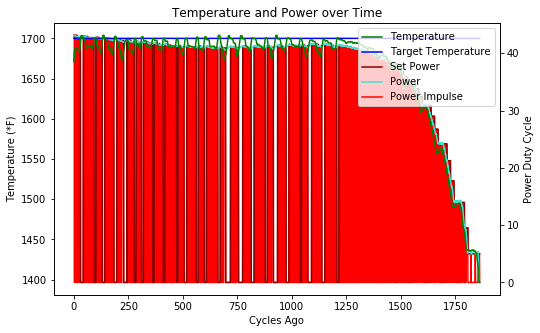

None

Observer will start rendering in 143 cycles
Observer will start rendering in 133 cycles
Observer will start rendering in 123 cycles
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:59:17.905951 | cycle: 1896       | temperature: 1521.95    | target: 1700       | power: 43.60119   | powerOn: 1          | setPower: 45.832685  | haltPowerChange: 1896       | powerStep: 2.9675     | slope: -3.7528146 | accel: -1.8610269 | cyclesUntilTarget: 99999      | error: 178.05     | percentError: 10.473529  | realCycleTime: 0.731451   | lastTemperature: 1686.65   
Holding power constant
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:59:18.539948 | cycle: 1897       | temperature: 1519.25    | target: 1700       | power: 43.629152  | powerOn: 0          | setPower: 45.832685  | haltPowerChange: 1896       | powerStep: 3.0125     | slope: -2.7574562 | accel: -1.3676391 | cyclesUntilTarget: 99999      | error: 180.75     | percentError: 10.632353  | realCycleTime: 1.014522   | lastTemperature: 1

Tuning: Kiln=timestamp: 2021-10-05 15:59:28.886450 | cycle: 1913       | temperature: 1472.45    | target: 1700       | power: 43.876045  | powerOn: 0          | setPower: 48.845185  | haltPowerChange: 1912       | powerStep: 3.7925     | slope: -5.1624675 | accel: -1.4515782 | cyclesUntilTarget: 99999      | error: 227.55     | percentError: 13.385294  | realCycleTime: 0.640682   | lastTemperature: 1670.9    
Adding Energy
Tuned power to 52.637685373285926
Energizing
Tuning: Kiln=timestamp: 2021-10-05 15:59:29.614273 | cycle: 1914       | temperature: 1470.65    | target: 1700       | power: 43.854474  | powerOn: 1          | setPower: 52.637685  | haltPowerChange: 1928       | powerStep: 3.8225     | slope: -4.4574264 | accel: -1.1605742 | cyclesUntilTarget: 99999      | error: 229.35     | percentError: 13.491176  | realCycleTime: 0.730242   | lastTemperature: 1665.95   
Holding power constant
Too Much Energy
Tuning: Kiln=timestamp: 2021-10-05 15:59:30.249463 | cycle: 1915       | t

In [ ]:
k.run(1700)

In [ ]:
k.controller.power.off()